# Install Required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install opencv-python

In [ ]:
!pip install keras-vggface

In [ ]:
!pip install keras==2.12
!pip install git+https://github.com/rcmalli/keras-vggface.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-u62vd2d2
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-u62vd2d2
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import urllib.request
from zipfile import ZipFile
import tarfile
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import bz2
import shutil
import gdown
import gzip
from skimage import io
import pickle

In [ ]:
from keras_vggface.vggface import VGGFace
from keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Reshape, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input

# Download Dataset

In [ ]:
# Function to download and extract the dataset
def download_and_extract(dataset_url, download_path='datasets/normal_face.tgz', extract_path='datasets/normal_faces', remove_file = True):
    if not os.path.exists(extract_path):
        os.makedirs(os.path.dirname(download_path), exist_ok = True)
        print("Downloading dataset...")
        urllib.request.urlretrieve(dataset_url, download_path)
        print("Download complete.")

        # Extract the zip file
        print("Extracting dataset...")
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(path=os.path.dirname(extract_path))
        print("Extraction complete.")

        # Optionally, remove the zip file
        if remove_file:
            os.remove(download_path)
            print('Tar.gz file removed.')

        print("Dataset ready.")
    else:
        print("Dataset already downloaded and extracted.")

In [ ]:
# URL of the LFW dataset
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
# Set download to false if the download is not needed
download = True
if download:
    download_and_extract(dataset_url = lfw_url, remove_file = False)
    download = False

Download complete.
Extracting dataset...
Extraction complete.
Dataset ready.


In [ ]:
## RUN WITH CAUTION ##
def delete_non_empty_directory(dir_path, delete = False):
    if delete:
      # Check if the directory exists
      if os.path.exists(dir_path):
        # Remove the directory and all its contents
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_path}' has been removed along with all its contents.")
      else:
        print(f"The directory '{dir_path}' does not exist.")
    else:
      print('No directory deleted.')

# Usage
directory_to_delete = "modified_datasets"
delete_non_empty_directory(directory_to_delete, False)

Directory 'modified_datasets' has been removed along with all its contents.


# Blurring features

In [ ]:
def download_dlib_model(url, bz2_filename, dat_filename, remove_file = False):
    # Check if the decompressed .dat file already exists
    if not os.path.isfile(dat_filename):
        # Check if the compressed .bz2 file already exists
        if not os.path.isfile(bz2_filename):
            print(f"Downloading {bz2_filename}...")
            urllib.request.urlretrieve(url, bz2_filename)
            print(f"Downloaded {bz2_filename}.")

        # Decompress the .bz2 file to get the .dat file
        print(f"Decompressing {bz2_filename} to get {dat_filename}...")
        with bz2.BZ2File(bz2_filename, 'rb') as f_in:
            with open(dat_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {dat_filename}.")

        # Optionally, remove the .bz2 file after decompression
        if remove_file:
          os.remove(bz2_filename)
          print(f"Removed compressed file {bz2_filename}.")
    else:
        print(f"{dat_filename} already exists. No download needed.")

# URL to the dlib pre-trained facial landmark predictor
dlib_model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the compressed model
compressed_file_name = "shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the decompressed model
model_file_name = "shape_predictor_68_face_landmarks.dat"

# Call the function to download and decompress the model
download_dlib_model(dlib_model_url, compressed_file_name, model_file_name)

Downloaded shape_predictor_68_face_landmarks.dat.bz2.
Decompressing shape_predictor_68_face_landmarks.dat.bz2 to get shape_predictor_68_face_landmarks.dat...
Decompressed to shape_predictor_68_face_landmarks.dat.


In [ ]:
# Initialize dlib face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
def blur_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a blurring effect to specific features on the face by fitting an ellipse around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to blur.
    feature_type (str): The type of feature to blur ('eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature blurred.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull (the smallest convex polygon containing all points) for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points, which provides a better fit than an ellipse
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Depending on the feature, adjust the box dimensions
    if feature_type in ['eyes', 'mouth']:
        # For the eyes and mouth, expand the box horizontally
        center, size, angle = rect
        size = (size[0] * 1.4, size[1] * 1.2)  # Increase the size a bit for better coverage
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask
    cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)

    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Combine the original and blurred images using the mask
    combined_image = np.where(mask[..., None].astype(bool), blurred_image, image)

    return combined_image

In [ ]:
def mask_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a black mask to specific features on the face by fitting a rotated rectangle around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to mask.
    feature_type (str): The type of feature to mask ('eyebrows', 'eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature masked with a black box.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Adjust the box dimensions based on the feature
    if feature_type in ['eyes', 'mouth', 'eyebrows']:
        # For the eyes, mouth, and eyebrows, expand the box slightly for better coverage
        center, size, angle = rect
        if feature_type == 'eyebrows':
            size = (size[0] * 1.2, size[1] * 1.5)  # Eyebrows are thinner but wider
        else:
            size = (size[0] * 1.4, size[1] * 1.2)  # Eyes and mouth
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box more vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask with white color
    cv2.drawContours(mask, [box], 0, (255), -1)

    # Mask the feature by setting the pixels inside the mask to black in the original image
    image[mask == 255] = [0, 0, 0]  # Set to black

    return image


In [ ]:
from skimage import io
detector = dlib.get_frontal_face_detector()
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Path to the facial landmark predictor file
predictor = dlib.shape_predictor(predictor_path)  # Load the facial landmark predictor

# Function to save an image
def save_image(image, path, filename):
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(os.path.join(path, filename), image)

def check_feature_visibility(landmarks, indices):
    """ Check if all indices in a feature have detectable landmarks """
    return all(landmarks.part(i) for i in indices)

def create_and_save_masked_datasets(base_path, save_path, target_size=(224, 224)):
    labels = {'normal': [], 'masked_eyebrows': [], 'masked_eyes': [], 'masked_nose': [], 'masked_mouth': []}

    for individual in os.listdir(os.path.join(base_path, 'lfw')):
        individual_path = os.path.join(base_path, 'lfw', individual)

        for image_file in os.listdir(individual_path):
            if image_file.lower().endswith('.jpg'):
                image_path = os.path.join(individual_path, image_file)
                image = io.imread(image_path)
                image = cv2.resize(image, target_size)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                faces = detector(gray, 1)
                face_detected = False
                if len(faces) > 0:
                    face = faces[0]
                    landmarks = predictor(gray, face)
                    # Indices for eyebrows, eyes, nose, and mouth features
                    eyebrows_indices = list(range(17, 27))  # Add eyebrows
                    eyes_indices = list(range(36, 42)) + list(range(42, 48))
                    nose_indices = list(range(27, 36))
                    mouth_indices = list(range(48, 68))

                    # Check visibility of each feature
                    has_eyebrows = check_feature_visibility(landmarks, eyebrows_indices)
                    has_eyes = check_feature_visibility(landmarks, eyes_indices)
                    has_nose = check_feature_visibility(landmarks, nose_indices)
                    has_mouth = check_feature_visibility(landmarks, mouth_indices)

                    if has_eyebrows and has_eyes and has_nose and has_mouth:
                        face_detected = True
                        masked_eyebrows = mask_feature(image.copy(), landmarks, eyebrows_indices, 'eyebrows')
                        masked_eyes = mask_feature(image.copy(), landmarks, eyes_indices, 'eyes')
                        masked_nose = mask_feature(image.copy(), landmarks, nose_indices, 'nose')
                        masked_mouth = mask_feature(image.copy(), landmarks, mouth_indices, 'mouth')
                    else:
                        masked_eyebrows, masked_eyes, masked_nose, masked_mouth = image.copy(), image.copy(), image.copy(), image.copy()

                save_image(image, os.path.join(save_path, 'normal'), image_file)
                save_image(masked_eyebrows, os.path.join(save_path, 'masked_eyebrows'), image_file)
                save_image(masked_eyes, os.path.join(save_path, 'masked_eyes'), image_file)
                save_image(masked_nose, os.path.join(save_path, 'masked_nose'), image_file)
                save_image(masked_mouth, os.path.join(save_path, 'masked_mouth'), image_file)

                # Update labels based on the feature visibility
                face_label = 1 if face_detected else 0
                labels['normal'].append(face_label)
                labels['masked_eyebrows'].append(face_label)
                labels['masked_eyes'].append(face_label)
                labels['masked_nose'].append(face_label)
                labels['masked_mouth'].append(face_label)

    for key in labels:
        labels_path = os.path.join(save_path, key)
        if not os.path.exists(labels_path):
            os.makedirs(labels_path)
        np.save(os.path.join(labels_path, 'labels.npy'), np.array(labels[key]))

In [ ]:
# Example usage of the function
base_path = 'datasets'  # Base path to the LFW dataset
save_path = 'modified_datasets'  # Path where you want to save the new datasets
create_and_save_masked_datasets(base_path, save_path)

# Loading Images for Training

In [ ]:
def load_images_from_directory(directory, label_file, target_size=(224, 224)):
    """
    Loads images from a directory and their corresponding labels from a .npy file.
    Assumes that images are named in such a way that sorting them alphabetically
    matches the order of labels in the label file.
    """
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    image_files.sort()  # Sort files to ensure correct order with labels

    images = []
    for filename in image_files:
        filepath = os.path.join(directory, filename)
        image = cv2.imread(filepath)
        if image is not None:
            image = cv2.resize(image, target_size)
            images.append(image)

    # Load labels from the .npy file
    labels = np.load(label_file)

    # Convert list of images to a numpy array
    images = np.array(images)

    return images, labels

In [ ]:
from sklearn.model_selection import train_test_split
def save_datasets_memory_map(X_train, X_val, X_test, y_train, y_val, y_test, save_path):
    os.makedirs(save_path, exist_ok=True)
    np.save(os.path.join(save_path, 'X_train.npy'), X_train)
    np.save(os.path.join(save_path, 'X_val.npy'), X_val)
    np.save(os.path.join(save_path, 'X_test.npy'), X_test)
    np.save(os.path.join(save_path, 'y_train.npy'), y_train)
    np.save(os.path.join(save_path, 'y_val.npy'), y_val)
    np.save(os.path.join(save_path, 'y_test.npy'), y_test)

def split_data(images, labels, save_path, test_size=0.2, val_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
    # save datasets as memory maps
    save_datasets_memory_map(X_train, X_val, X_test, y_train, y_val, y_test, save_path)
    return None

In [ ]:
def load_data_from_files(save_path):
    X_train = np.load(os.path.join(save_path, 'X_train.npy'), mmap_mode='r')
    X_test = np.load(os.path.join(save_path, 'X_test.npy'), mmap_mode='r')
    X_val = np.load(os.path.join(save_path, 'X_val.npy'), mmap_mode='r')
    y_train = np.load(os.path.join(save_path, 'y_train.npy'), mmap_mode='r')
    y_test = np.load(os.path.join(save_path, 'y_test.npy'), mmap_mode='r')
    y_val = np.load(os.path.join(save_path, 'y_val.npy'), mmap_mode='r')
    return X_train, X_test, X_val, y_train, y_test, y_val

# Metrics

1. **Precision** measures the accuracy of positive predictions (i.e., the proportion of predicted positives that are actually true positives).
2. **Recall** measures the ability of the classifier to find all the positive samples (i.e., how well the model can detect actual positives from the dataset).
3. **F1 Score** is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.
4. **Confusion Matrix** is a table used to describe the performance of a classification model on a set of data for which the true values are known. It provides insights not just into the errors being made by a classifier but more importantly the types of errors.

In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def calculate_precision_recall_f1(y_true, y_pred):
    # True positives, false positives, false negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
def confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix components
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Forming the confusion matrix
    cm = np.array([[tn, fp],
                   [fn, tp]])
    return cm

In [ ]:
def plot_confusion_matrix(cm, classes=['Not Detected', 'Detected'],
                          title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_model_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

Precision: 0.6
Recall: 0.6
F1 Score: 0.6


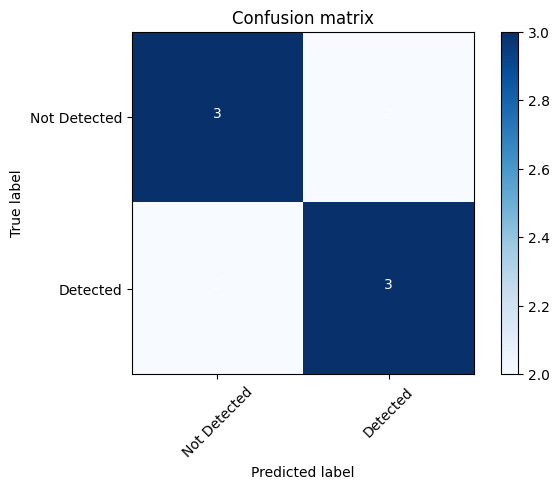

In [ ]:
# Example usage
# Sample labels (0: not detected, 1: detected)
y_true = np.array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1])
y_pred = np.array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)


# Load the data for all the datasets


In [ ]:
# Load images and labels - normal dataset
directory = 'modified_datasets/normal'
label_file = 'modified_datasets/normal/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/normal'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data_from_files(save_path)

In [ ]:
# Load images and labels - eyebrows
directory = 'modified_datasets/masked_eyebrows'
label_file = 'modified_datasets/masked_eyebrows/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_eyebrows'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_brows, X_test_brows, X_val_brows, y_train_brows, y_test_brows, y_val_brows = load_data_from_files(save_path)

In [ ]:
# Load images and labels - eyes
directory = 'modified_datasets/masked_eyes'
label_file = 'modified_datasets/masked_eyes/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_eyes'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_eyes, X_test_eyes, X_val_eyes, y_train_eyes, y_test_eyes, y_val_eyes = load_data_from_files(save_path)

In [ ]:
# Load images and labels - nose
directory = 'modified_datasets/masked_nose'
label_file = 'modified_datasets/masked_nose/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_nose'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_nose, X_test_nose, X_val_nose, y_train_nose, y_test_nose, y_val_nose = load_data_from_files(save_path)

In [ ]:
# Load images and labels - mouth
directory = 'modified_datasets/masked_mouth'
label_file = 'modified_datasets/masked_mouth/labels.npy'
images, labels = load_images_from_directory(directory, label_file)
save_path = 'modified_datasets/masked_mouth'

# Split data
split_data(images, labels, save_path)
# Load the data
X_train_mouth, X_test_mouth, X_val_mouth, y_train_mouth, y_test_mouth, y_val_noise = load_data_from_files(save_path)

## Let's do this from scratch - one final time!!

# Original Model

In [ ]:
from keras.backend import clear_session
# Original model
def build_model():
  # Load VGGFace model
  base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

  # Add new classifier layers
  flat1 = Flatten()(base_model.output)
  output = Dense(1, activation='sigmoid')(flat1)
  final_model = Model(inputs=base_model.inputs, outputs=output)

  # Compile the model
  final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Display model summary
  # final_model.summary()

  return final_model


# Reset the Keras session
clear_session()
# build the model
face_model = build_model()

In [ ]:
face_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# Training the model on good data
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Set up callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = face_model.fit(X_train, y_train, epochs=10, batch_size=20,
                         validation_data=(X_val, y_val),
                         callbacks=[checkpoint, early_stop])

Epoch 1/10
477/477 [==============================] - 74s 155ms/step - loss: 36393.7578 - accuracy: 0.9931 - val_loss: 0.5179 - val_accuracy: 0.9981
Epoch 2/10
477/477 [==============================] - 69s 144ms/step - loss: 0.4227 - accuracy: 0.9931 - val_loss: 0.3423 - val_accuracy: 0.9981
Epoch 3/10
477/477 [==============================] - 69s 144ms/step - loss: 0.2957 - accuracy: 0.9931 - val_loss: 0.2454 - val_accuracy: 0.9981
Epoch 4/10
477/477 [==============================] - 69s 144ms/step - loss: 0.2195 - accuracy: 0.9931 - val_loss: 0.1829 - val_accuracy: 0.9981
Epoch 5/10
477/477 [==============================] - 69s 145ms/step - loss: 0.1693 - accuracy: 0.9931 - val_loss: 0.1403 - val_accuracy: 0.9981
Epoch 6/10
477/477 [==============================] - 69s 145ms/step - loss: 0.1347 - accuracy: 0.9931 - val_loss: 0.1100 - val_accuracy: 0.9981
Epoch 7/10
477/477 [==============================] - 69s 145ms/step - loss: 0.1101 - accuracy: 0.9931 - val_loss: 0.0879 - va

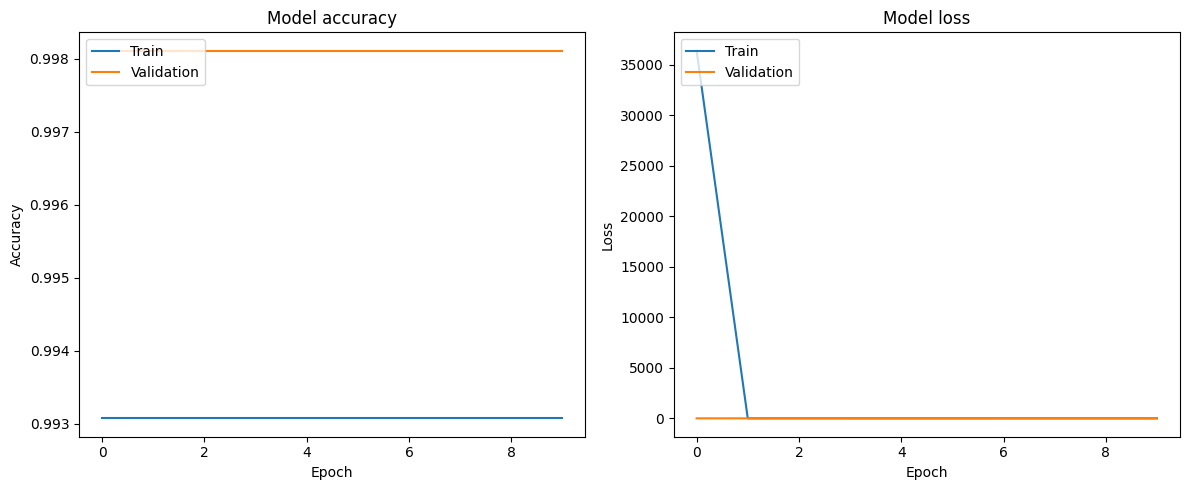

In [ ]:
# Plot the metrics
plot_model_metrics(history)

# Activation Maps

In [ ]:
# Activation Heat maps
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import cv2

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Model with both the last CNN layer and classifier layers output
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output] + [model.get_layer(name).output for name in classifier_layer_names])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Forward pass
        last_conv_layer_output, preds = grad_model(img_array)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # Gradient of top predicted class with respect to the output feature map of last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This vector contains importance weights of each channel in feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels by their importance to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to plot the original image and heatmaps
def plot_heatmaps(img_path, model, layers, classifier_layer_names):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = preprocess_input(img)  # Add your preprocessing logic here
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Plot original image
    plt.figure(figsize=(10, 3))
    plt.subplot(1, len(layers) + 1, 1)
    plt.imshow(img)
    plt.axis('off')

    # Generate and plot heatmaps for each layer
    for i, layer in enumerate(layers, start=2):
        heatmap = make_gradcam_heatmap(img_array, model, layer, classifier_layer_names)
        plt.subplot(1, len(layers) + 1, i)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
        plt.title(layer)
        plt.axis('off')

    plt.tight_layout()
    plt.colorbar()
    plt.show()

# List of layers to check
later_layers = ['conv5_1', 'conv5_2', 'conv5_3']
early_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2']
middle_layers = ['conv4_1', 'conv4_2', 'conv4_3']
classifier_layer_names = ["dense"]  # Names of classifier layers in your model

# Define paths to your datasets
image_paths = {
    'normal': 'modified_datasets/normal/AJ_Cook_0001.jpg',
    'eyebrows': 'modified_datasets/masked_eyebrows/AJ_Cook_0001.jpg',
    'eyes': 'modified_datasets/masked_eyes/AJ_Cook_0001.jpg',
    'nose': 'modified_datasets/masked_nose/AJ_Cook_0001.jpg',
    'mouth': 'modified_datasets/masked_mouth/AJ_Cook_0001.jpg'
}

Analyzing feature: normal


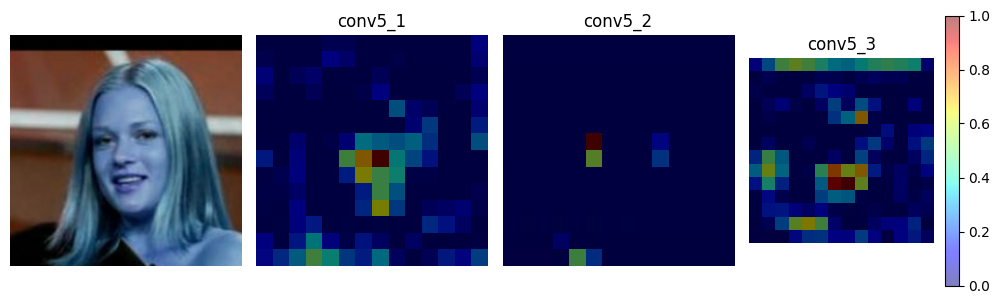

Analyzing feature: eyebrows


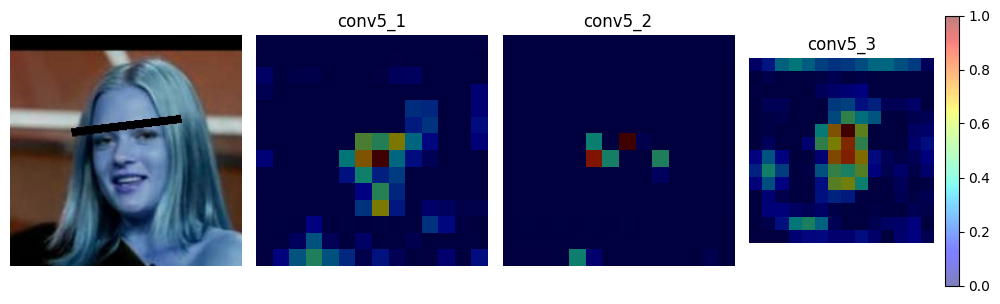

Analyzing feature: eyes


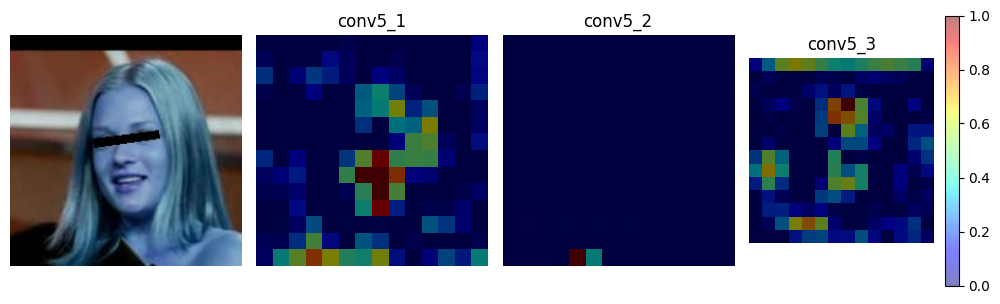

Analyzing feature: nose


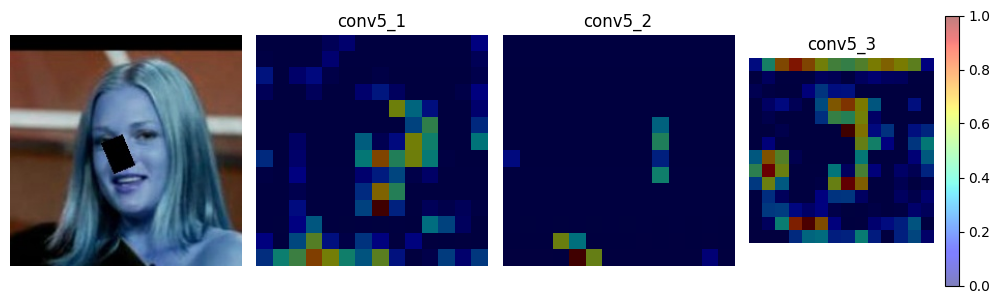

Analyzing feature: mouth


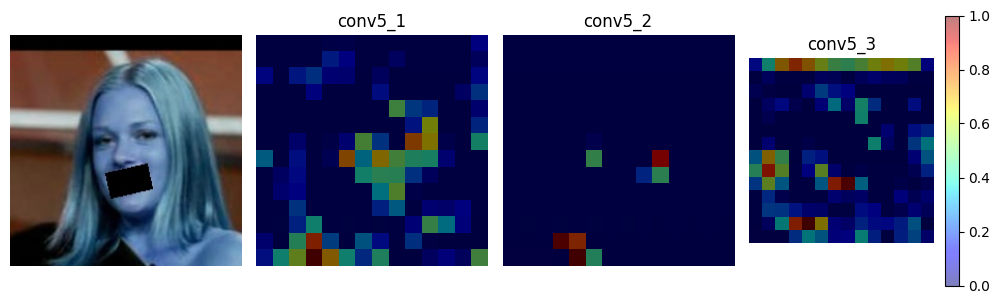

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, later_layers, classifier_layer_names)

Analyzing feature: normal


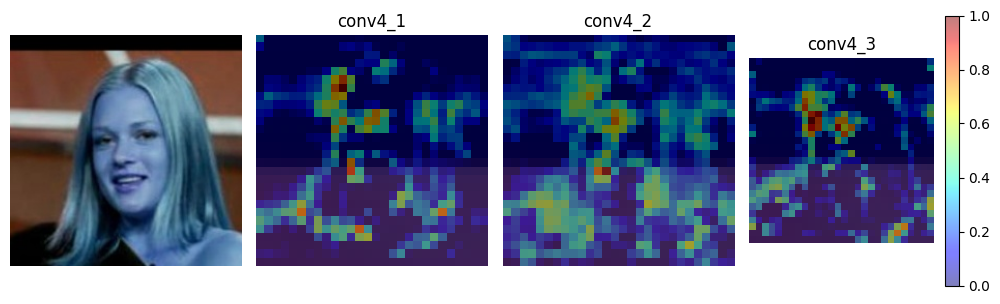

Analyzing feature: eyebrows


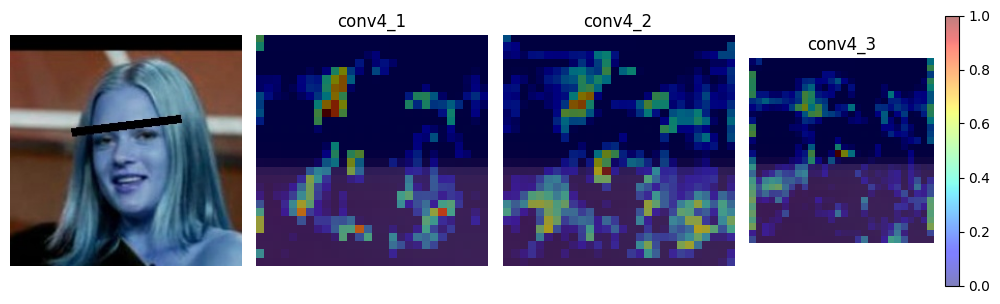

Analyzing feature: eyes


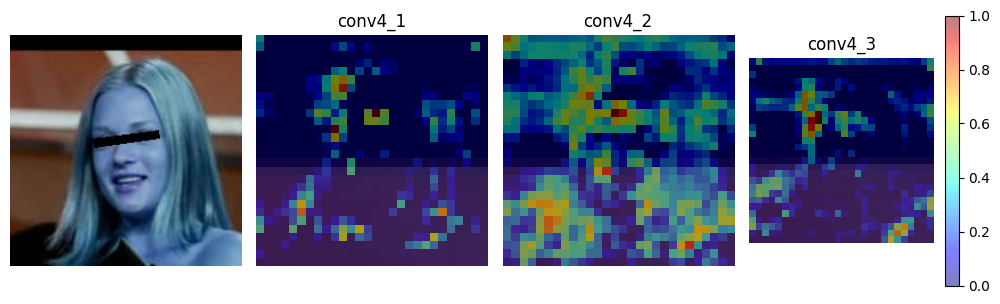

Analyzing feature: nose


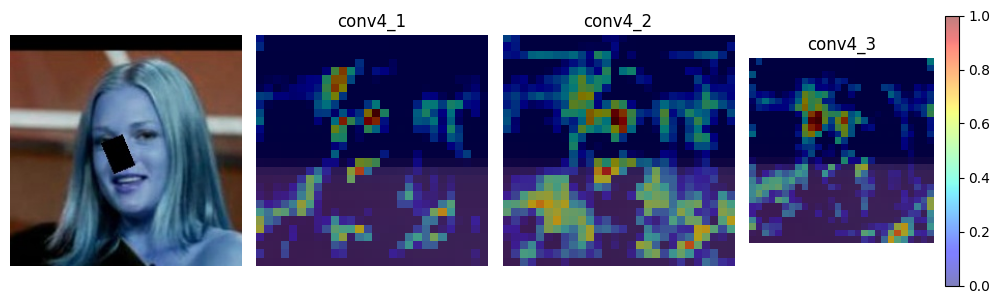

Analyzing feature: mouth


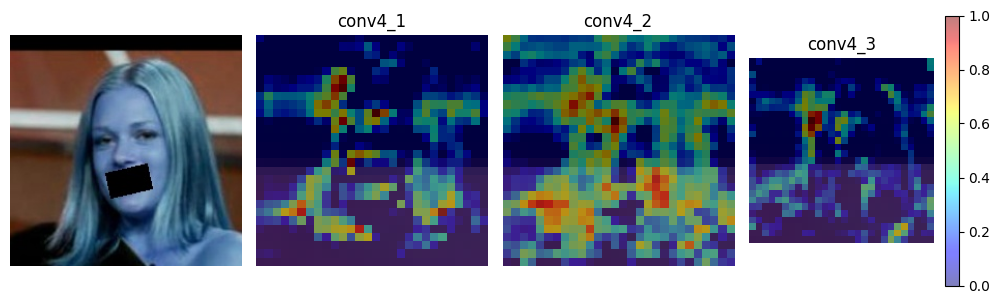

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, middle_layers, classifier_layer_names)

Analyzing feature: normal


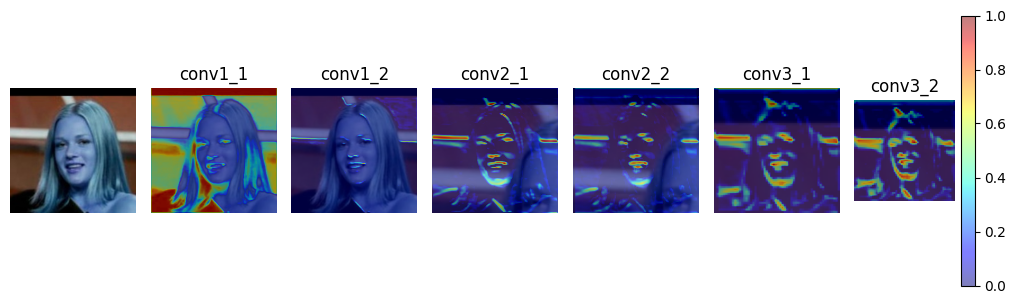

Analyzing feature: eyebrows


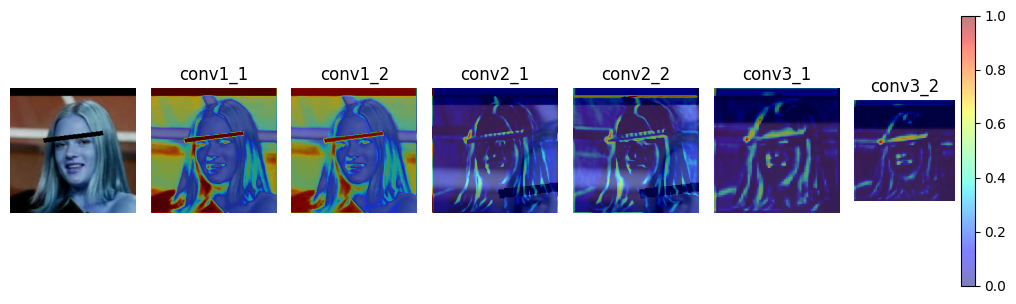

Analyzing feature: eyes


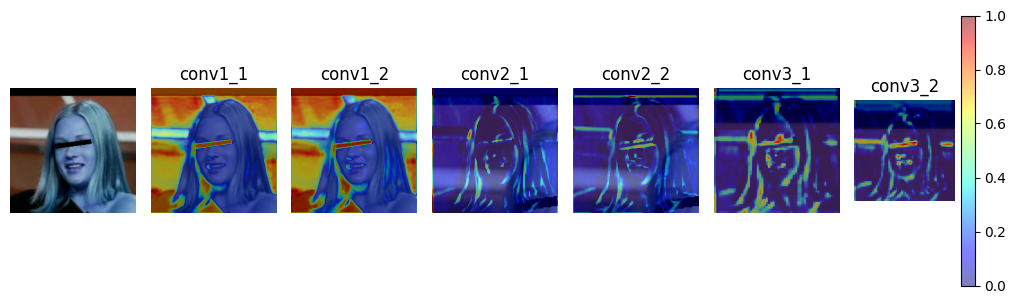

Analyzing feature: nose


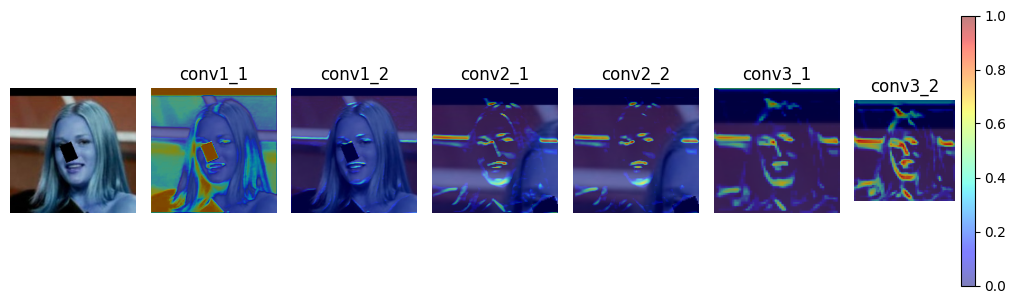

Analyzing feature: mouth


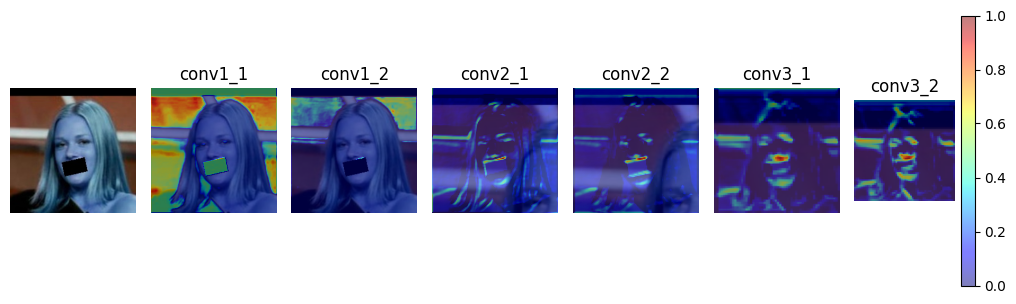

In [ ]:
# Loop over the datasets and plot the heatmaps
for feature, img_path in image_paths.items():
    print(f"Analyzing feature: {feature}")
    plot_heatmaps(img_path, face_model, early_layers, classifier_layer_names)

# Performance of Original Model

In [ ]:
# orignal model's performance on normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

num_runs = 5
total_accuracy = 0

for run in range(num_runs):
  clear_session()
  face_model = build_model()

  predictions = face_model.predict(test_images)
  binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

  # Calculate accuracy
  num_correct = 0
  total_images = len(test_images)
  for i in range(total_images):
      predicted_class = binary_predictions[i]
      true_class = test_labels[i]
      if predicted_class == true_class:
          num_correct += 1

  accuracy = num_correct / total_images
  total_accuracy += accuracy
  print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")
# Calculate the average accuracy over all runs
avg_accuracy = total_accuracy / num_runs
print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")





# # Make predictions using the model
# # predictions = final_model.predict(test_images)
# predictions = face_model.predict(test_images)
# binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# # Calculate accuracy
# num_correct = 0
# total_images = len(test_images)

# for i in range(total_images):
#     predicted_class = binary_predictions[i]
#     true_class = test_labels[i]
#     if predicted_class == true_class:
#         num_correct += 1

# accuracy = num_correct / total_images
# print("Original model accuracy with normal data", accuracy)

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 23.04%
83/83 [==============================] - 8s 91ms/step
Run 2: Accuracy = 50.40%
83/83 [==============================] - 8s 91ms/step
Run 3: Accuracy = 96.49%
83/83 [==============================] - 8s 92ms/step
Run 4: Accuracy = 96.41%
83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 98.56%
Average Accuracy over 5 runs: 72.98%


Precision: 0.9950400610454025
Recall: 0.9905051272312951
F1 Score: 0.9927674153026266


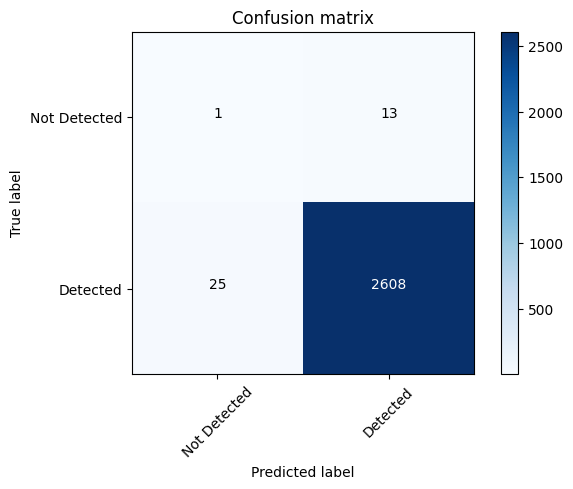

In [ ]:
# performace on normal data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

num_runs = 5
total_accuracy = 0

for run in range(num_runs):
  clear_session()
  face_model = build_model()

  predictions = face_model.predict(test_images)
  binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

  # Calculate accuracy
  num_correct = 0
  total_images = len(test_images)
  for i in range(total_images):
      predicted_class = binary_predictions[i]
      true_class = test_labels[i]
      if predicted_class == true_class:
          num_correct += 1

  accuracy = num_correct / total_images
  total_accuracy += accuracy
  print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")
# Calculate the average accuracy over all runs
avg_accuracy = total_accuracy / num_runs
print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 92ms/step
Run 1: Accuracy = 97.24%
83/83 [==============================] - 8s 92ms/step
Run 2: Accuracy = 86.89%
83/83 [==============================] - 8s 93ms/step
Run 3: Accuracy = 3.70%
83/83 [==============================] - 8s 93ms/step
Run 4: Accuracy = 95.92%
83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 24.22%
Average Accuracy over 5 runs: 61.59%


Precision: 0.995253164556962
Recall: 0.23898176291793313
F1 Score: 0.3854166666666667


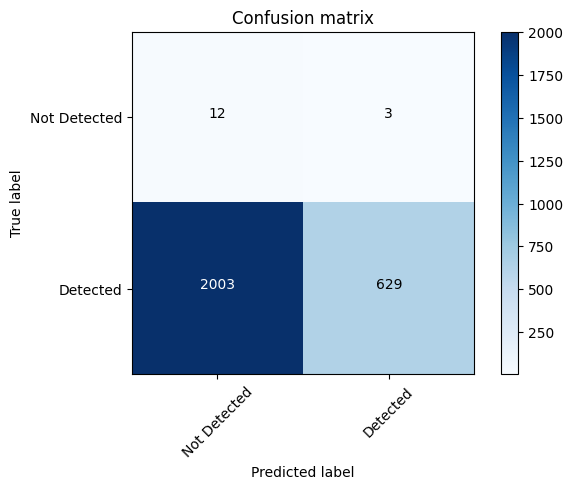

In [ ]:
# performace on masked data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

num_runs = 5
total_accuracy = 0

for run in range(num_runs):
  clear_session()
  face_model = build_model()

  predictions = face_model.predict(test_images)
  binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

  # Calculate accuracy
  num_correct = 0
  total_images = len(test_images)
  for i in range(total_images):
      predicted_class = binary_predictions[i]
      true_class = test_labels[i]
      if predicted_class == true_class:
          num_correct += 1

  accuracy = num_correct / total_images
  total_accuracy += accuracy
  print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")
# Calculate the average accuracy over all runs
avg_accuracy = total_accuracy / num_runs
print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 83.83%
83/83 [==============================] - 8s 91ms/step
Run 2: Accuracy = 25.39%
83/83 [==============================] - 8s 93ms/step
Run 3: Accuracy = 61.09%
83/83 [==============================] - 8s 94ms/step
Run 4: Accuracy = 29.88%
83/83 [==============================] - 8s 95ms/step
Run 5: Accuracy = 71.06%
Average Accuracy over 5 runs: 54.25%


Precision: 0.9936541512427287
Recall: 0.7136346372958602
F1 Score: 0.8306808134394341


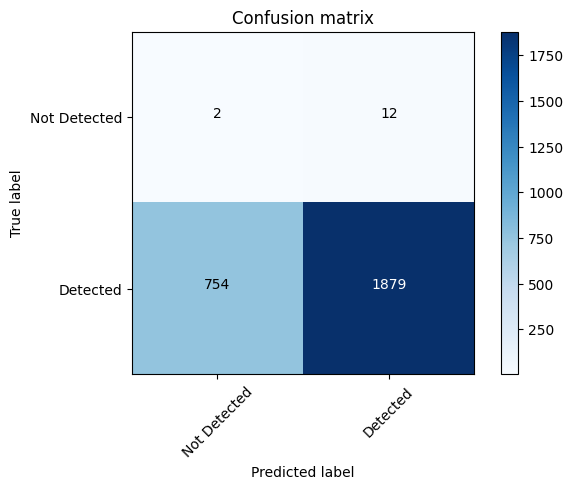

In [ ]:
# performace on masked eyes
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

num_runs = 5
total_accuracy = 0

for run in range(num_runs):
  clear_session()
  face_model = build_model()

  predictions = face_model.predict(test_images)
  binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

  # Calculate accuracy
  num_correct = 0
  total_images = len(test_images)
  for i in range(total_images):
      predicted_class = binary_predictions[i]
      true_class = test_labels[i]
      if predicted_class == true_class:
          num_correct += 1

  accuracy = num_correct / total_images
  total_accuracy += accuracy
  print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")
# Calculate the average accuracy over all runs
avg_accuracy = total_accuracy / num_runs
print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 94ms/step
Run 1: Accuracy = 75.29%
83/83 [==============================] - 8s 94ms/step
Run 2: Accuracy = 38.87%
83/83 [==============================] - 8s 94ms/step
Run 3: Accuracy = 77.22%
83/83 [==============================] - 8s 95ms/step
Run 4: Accuracy = 77.18%
83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 76.24%
Average Accuracy over 5 runs: 68.96%


Precision: 0.9945705824284304
Recall: 0.7652867451576149
F1 Score: 0.8649924876582958


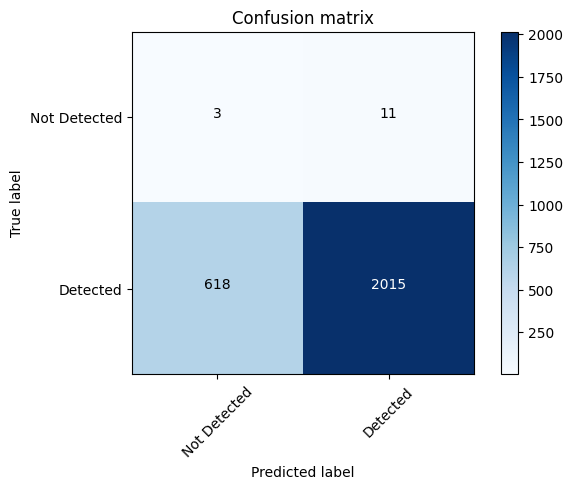

In [ ]:
# performace on masked nose
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
# clear_session()
# face_model = build_model()
# # orignal model's performance on normal data
# # Load the test dataset
# test_images = X_test_mouth # Load your test images here
# test_labels = y_test_mouth # Load your test labels here

# # Define a threshold for classifying as face detected
# threshold = 0.5

# # Make predictions using the model
# # predictions = final_model.predict(test_images)
# predictions = face_model.predict(test_images)
# binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# # Calculate accuracy
# num_correct = 0
# total_images = len(test_images)

# for i in range(total_images):
#     predicted_class = binary_predictions[i]
#     true_class = test_labels[i]
#     if predicted_class == true_class:
#         num_correct += 1

# accuracy = num_correct / total_images
# print("Original model accuracy with masked mouth data", accuracy)

test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

num_runs = 5
total_accuracy = 0

for run in range(num_runs):
  clear_session()
  face_model = build_model()

  predictions = face_model.predict(test_images)
  binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

  # Calculate accuracy
  num_correct = 0
  total_images = len(test_images)
  for i in range(total_images):
      predicted_class = binary_predictions[i]
      true_class = test_labels[i]
      if predicted_class == true_class:
          num_correct += 1

  accuracy = num_correct / total_images
  total_accuracy += accuracy
  print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")
# Calculate the average accuracy over all runs
avg_accuracy = total_accuracy / num_runs
print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 99.43%
83/83 [==============================] - 8s 94ms/step
Run 2: Accuracy = 0.72%
83/83 [==============================] - 8s 95ms/step
Run 3: Accuracy = 56.37%
83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 0.60%
83/83 [==============================] - 8s 98ms/step
Run 5: Accuracy = 94.30%
Average Accuracy over 5 runs: 50.28%


Precision: 0.9952114924181963
Recall: 0.9472085074060007
F1 Score: 0.9706168515275345


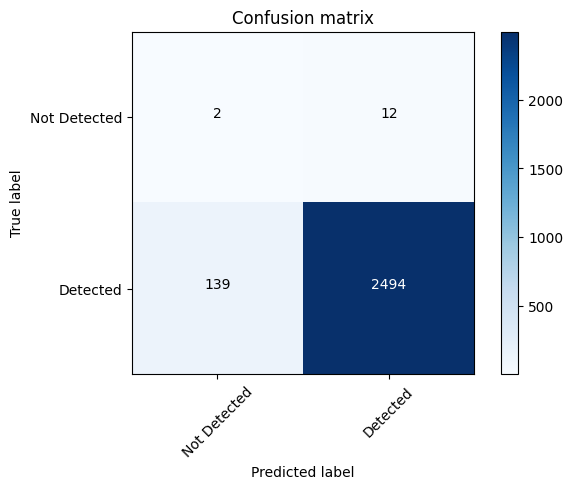

In [ ]:
# performace on masked_mouth
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

# Neurological Deficits

## Prepare Dataste for Training for Deficit Models

In [ ]:
datasets = [(X_train_eyes, y_train_eyes), (X_train_nose, y_train_nose), (X_train_brows, y_train_brows), (X_train_mouth, y_train_mouth)]
X_train_combined = np.vstack([data[0] for data in datasets])
y_train_combined = np.hstack([data[1] for data in datasets])

# Shuffle the combined dataset
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train_combined = X_train_combined[indices]
y_train_combined = y_train_combined[indices]

# Optionally limit the dataset to the first 10000 samples
X_train_deficit = X_train_combined[:10000]
y_train_deficit = y_train_combined[:10000]

## Approach 1: Feature Ablation


In [ ]:
# Neurological deficit  - ablate conv4_3 to conv5_3

from keras.models import Model
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Flatten, Dense, Lambda
import tensorflow as tf

def build_model_with_ablation(ablation_layers):
    # Load VGGFace model
    base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Function to zero-out activations
    def ablate_features(x, layers_to_ablate):
        for layer_name in layers_to_ablate:
            if base_model.get_layer(layer_name) == x.name:
                return tf.zeros_like(x)
        return x

    # Add ablation layers after convolutional layers
    x = base_model.input
    for layer in base_model.layers:
        layer_output = layer(x)
        # Apply ablation if the layer is in the ablation list
        x = Lambda(lambda x: ablate_features(x, ablation_layers), name=f'ablated_{layer.name}')(layer_output)

    # Add new classifier layers
    flat1 = Flatten()(x)
    output = Dense(1, activation='sigmoid')(flat1)

    # Define the new model
    model_with_ablation = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model_with_ablation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_with_ablation

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
layers_to_ablate = ['conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# Build the model with feature ablation
face_model_with_ablation = build_model_with_ablation(layers_to_ablate)

# Display the summary to confirm the ablation layers are included
face_model_with_ablation.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 ablated_input_2 (Lambda)       (None, 224, 224, 3)  0           ['input_2[1][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_2[0][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

In [ ]:
# Train the ablated model for layers conv4_3 to conv5_3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Set up callbacks
checkpoint = ModelCheckpoint('ablation_model_1.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_ablation = face_model_with_ablation.fit(X_train_deficit, y_train_deficit, validation_split=0.2, epochs=5, batch_size=32, callbacks=[checkpoint, early_stop])

Epoch 1/5
239/239 [==============================] - 60s 252ms/step - loss: 0.0908 - accuracy: 0.9933 - val_loss: 0.0353 - val_accuracy: 0.9958
Epoch 2/5
239/239 [==============================] - 59s 248ms/step - loss: 0.0648 - accuracy: 0.9934 - val_loss: 0.0365 - val_accuracy: 0.9958
Epoch 3/5
239/239 [==============================] - 60s 251ms/step - loss: 0.0752 - accuracy: 0.9934 - val_loss: 0.0303 - val_accuracy: 0.9958
Epoch 4/5
239/239 [==============================] - 59s 248ms/step - loss: 0.0484 - accuracy: 0.9934 - val_loss: 0.0292 - val_accuracy: 0.9958
Epoch 5/5
239/239 [==============================] - 59s 248ms/step - loss: 0.0452 - accuracy: 0.9934 - val_loss: 0.0350 - val_accuracy: 0.9958


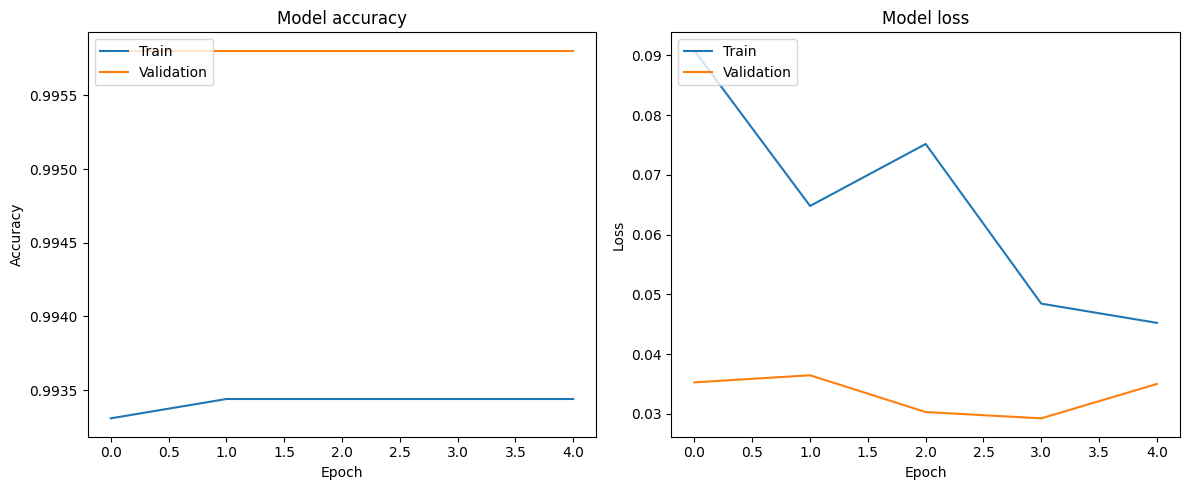

In [ ]:
# Plot metrics for this ablation
plot_model_metrics(history_ablation)

### Testing the Ablated Model

In [ ]:
import numpy as np
from tensorflow.keras.backend import clear_session

def calculate_accuracy(rebuild_model_func, rebuild_model_args, test_images, test_labels, threshold=0.5, num_runs=5):
    """
    Evaluate the model over a number of runs and return the average accuracy.

    :param rebuild_model_func: Function to rebuild the model.
    :param rebuild_model_args: Positional arguments for the rebuild model function.
    :param rebuild_model_kwargs: Keyword arguments for the rebuild model function.
    :param test_images: Array of test images.
    :param test_labels: Array of true labels for the test images.
    :param threshold: Threshold to convert predicted probabilities to binary predictions.
    :param num_runs: Number of runs to perform.
    :return: Average accuracy over the specified number of runs.
    """
    total_accuracy = 0

    # Perform training and evaluation in a loop
    for run in range(num_runs):
        # Reset the session
        clear_session()
        # Rebuild the model with the provided function and arguments
        model = rebuild_model_func(*rebuild_model_args)

        # Train the model (omitted for brevity)

        # Make predictions using the model
        predictions = model.predict(test_images)

        # Convert predictions to binary using the defined threshold
        binary_predictions = (predictions > threshold).astype(int).flatten()

        # Calculate accuracy
        num_correct = np.sum(binary_predictions == test_labels)
        accuracy = num_correct / len(test_labels)

        # Accumulate total accuracy
        total_accuracy += accuracy
        print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

    # Calculate the average accuracy over all runs
    avg_accuracy = total_accuracy / num_runs
    print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")
    return avg_accuracy, binary_predictions

In [ ]:
import gc

del accuracy, binary_predictions, test_labels, test_images
gc.collect()

129957

In [ ]:
accuracy, binary_predictions_normal = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test,
    test_labels=y_test)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 1: Accuracy = 47.07%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 2: Accuracy = 88.06%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 99ms/step
Run 3: Accuracy = 41.71%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 98ms/step
Run 4: Accuracy = 37.44%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 7.74%
Average Accuracy over 5 runs: 44.40%


Precision: 0.9948186528497409
Recall: 0.07292062286365363
F1 Score: 0.13588110403397025


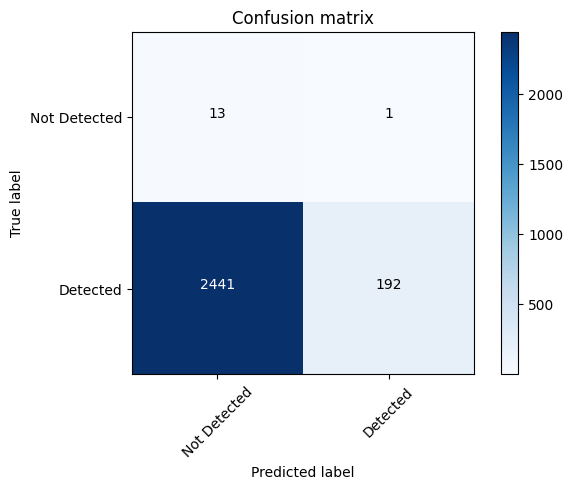

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions_normal

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
accuracy, binary_predictions_brows = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_brows,
    test_labels=y_test_brows)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 0.83%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 2: Accuracy = 98.53%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 3: Accuracy = 32.00%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 4: Accuracy = 25.35%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 5: Accuracy = 72.53%
Average Accuracy over 5 runs: 45.85%


In [ ]:
accuracy, binary_predictions_brows = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_brows,
    test_labels=y_test_brows)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 35.40%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 2: Accuracy = 97.77%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 3: Accuracy = 24.10%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 27.43%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 5: Accuracy = 3.55%
Average Accuracy over 5 runs: 37.65%


Precision: 0.9759036144578314
Recall: 0.030775075987841946
F1 Score: 0.059668508287292824


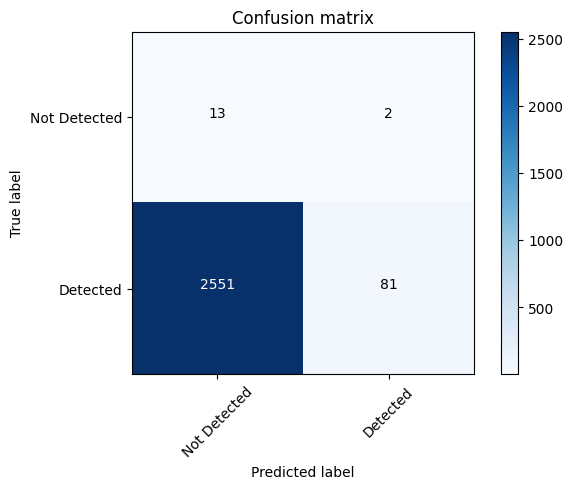

In [ ]:
# performace on masked_brows
y_true = y_test_brows
y_pred = binary_predictions_brows

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
accuracy, binary_predictions = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_eyes,
    test_labels=y_test_eyes)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 91ms/step
Run 1: Accuracy = 94.11%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 2: Accuracy = 94.79%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 3: Accuracy = 46.88%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 4: Accuracy = 16.06%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 5: Accuracy = 18.21%
Average Accuracy over 5 runs: 54.01%


Precision: 0.9936440677966102
Recall: 0.17812381314090392
F1 Score: 0.3020933977455717


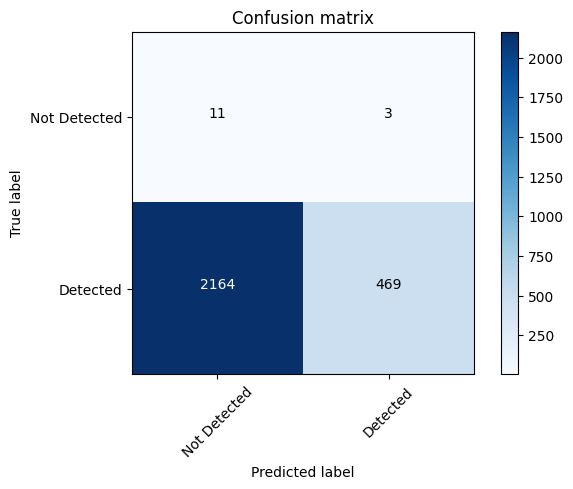

In [ ]:
# performace on masked eyes
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
# Test the ablated model - masked nose
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 92ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.36607480166225914


In [ ]:
accuracy, binary_predictions = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_nose,
    test_labels=y_test_nose)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 98.90%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 2: Accuracy = 0.98%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 3: Accuracy = 29.58%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 68.42%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 93.92%
Average Accuracy over 5 runs: 58.36%


Precision: 0.9947958366693355
Recall: 0.943790353209267
F1 Score: 0.9686221009549795


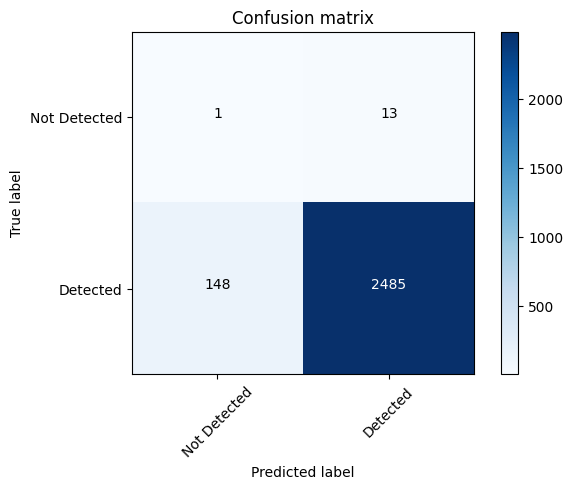

In [ ]:
# performace on masked nose
y_true = y_test_nose
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
# Test the ablated model - masked mouth
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = face_model_with_ablation.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 92ms/step
Face model with abalation accuracy [Ablated layers: conv4_3, conv5_1, conv5_2, conv5_3]: 0.47714393653192294


In [ ]:
accuracy, binary_predictions = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_mouth,
    test_labels=y_test_mouth)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 1: Accuracy = 51.15%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 2: Accuracy = 73.59%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 3: Accuracy = 93.39%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


41/83 [=============>................] - ETA: 3s

KeyboardInterrupt: 

In [ ]:
# performace on masked mouth
y_true = y_test_mouth
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

### Ablation Model [Grad-CAM Layers]

In [ ]:
# Specify the layers to be ablated based on Grad-CAM results
layers_to_ablate = [ 'conv3_2', 'conv4_2', 'conv5_3' ]

# Build the model with feature ablation
face_model_with_ablation_2 = build_model_with_ablation(layers_to_ablate)

# Display the summary to confirm the ablation layers are included
face_model_with_ablation_2.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 ablated_input_2 (Lambda)       (None, 224, 224, 3)  0           ['input_2[1][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_2[0][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

In [ ]:
# Train the Ablation Model 2
# Train the ablated model for layers conv4_3 to conv5_3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Set up callbacks
checkpoint = ModelCheckpoint('feature_ablation_2.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_ablation_2 = face_model_with_ablation_2.fit(X_train_deficit, y_train_deficit, validation_split = 0.2, epochs=5, batch_size=32, callbacks=[checkpoint, early_stop])

Epoch 1/5
239/239 [==============================] - 64s 253ms/step - loss: 239.4181 - accuracy: 0.9902 - val_loss: 0.0783 - val_accuracy: 0.9921
Epoch 2/5
 33/239 [===>..........................] - ETA: 46s - loss: 0.0613 - accuracy: 0.9934

KeyboardInterrupt: 

In [ ]:
# Plot the metrics
plot_model_metrics(history_ablation_2)

### Testing Abalation Model 2


In [ ]:
print(layers_to_ablate)

['conv3_2', 'conv4_2', 'conv5_3']


### Normal

In [ ]:
accuracy, binary_predictions_normal = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test,
    test_labels=y_test)

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions_normal

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

### Eyebrows

In [ ]:
# Call the function with arguments for a specific model rebuild function
accuracy, binary_predictions_brows = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_brows,
    test_labels=y_test_brows)

In [ ]:
# performace on normal data
y_true = y_test_brows
y_pred = binary_predictions_brows

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

### Eyes

In [ ]:
# Call the function with arguments for a specific model rebuild function
accuracy, binary_predictions_eyes = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_eyes,
    test_labels=y_test_eyes)

In [ ]:
# performace on normal data
y_true = y_test_eyes
y_pred = binary_predictions_eyes

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

### Nose

In [ ]:
# Call the function with arguments for a specific model rebuild function
accuracy, binary_predictions_nose = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_nose,
    test_labels=y_test_nose)

In [ ]:
# performace on normal data
y_true = y_test_nose
y_pred = binary_predictions_nose

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

### Mouth

In [ ]:
accuracy, binary_predictions_mouth = calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_mouth,
    test_labels=y_test_mouth)

In [ ]:
# performace on normal data
y_true = y_test_mouth
y_pred = binary_predictions_mouth

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_nose,
    test_labels=y_test_nose)

In [ ]:
calculate_accuracy(rebuild_model_func=build_model_with_ablation,
    rebuild_model_args=(layers_to_ablate,),
    test_images=X_test_mouth,
    test_labels=y_test_mouth)

## Approach 2: Noise Injection

In [ ]:
from keras.models import clone_model
from keras.layers import GaussianNoise

def add_noise_to_specific_layers(base_model, noise_layers, noise_level=0.1):
    """
    Adds Gaussian noise to the output of specific layers without modifying the base model.

    :param base_model: The base Keras model.
    :param noise_layers: A list of layer names to which noise should be added.
    :param noise_level: The standard deviation of the noise distribution.
    :return: A new model with noise injection.
    """
    # Clone the base model
    model_clone = clone_model(base_model)
    model_clone.set_weights(base_model.get_weights())

    # Rebuild model architecture and add noise to the specified layers
    x = model_clone.input
    for layer in model_clone.layers:
        if layer.name in noise_layers:
            # Add Gaussian noise after the specified layer
            x = GaussianNoise(noise_level)(layer(x))
        else:
            x = layer(x)

    # Create the new model with noise injection
    model_with_noise = Model(inputs=model_clone.input, outputs=x)
    model_with_noise.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_with_noise

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
noisy_layers = ['conv3_2', 'conv4_2', 'conv5_3']

# Build the model with feature ablation
noise_face_model = add_noise_to_specific_layers(face_model, noisy_layers, noise_level=0.8)


# Display the summary to confirm the ablation layers are included
noise_face_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
# Train the noisy model on bad data for layers conv4_3 to conv5_3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Set up callbacks
checkpoint = ModelCheckpoint('noise_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_noise = noise_face_model.fit(X_train_deficit, y_train_deficit, validation_split=0.2, epochs=5, batch_size=32, callbacks=[checkpoint, early_stop])

Epoch 1/5
239/239 [==============================] - 63s 263ms/step - loss: 0.0408 - accuracy: 0.9934 - val_loss: 0.1974 - val_accuracy: 0.9921
Epoch 2/5
239/239 [==============================] - 62s 261ms/step - loss: 0.0407 - accuracy: 0.9934 - val_loss: 0.3783 - val_accuracy: 0.9921
Epoch 3/5
239/239 [==============================] - 62s 261ms/step - loss: 0.0402 - accuracy: 0.9934 - val_loss: 0.3867 - val_accuracy: 0.9921
Epoch 4/5
239/239 [==============================] - 62s 261ms/step - loss: 0.0402 - accuracy: 0.9934 - val_loss: 0.5008 - val_accuracy: 0.9921
Epoch 5/5
239/239 [==============================] - 62s 261ms/step - loss: 0.0407 - accuracy: 0.9934 - val_loss: 0.4921 - val_accuracy: 0.9921


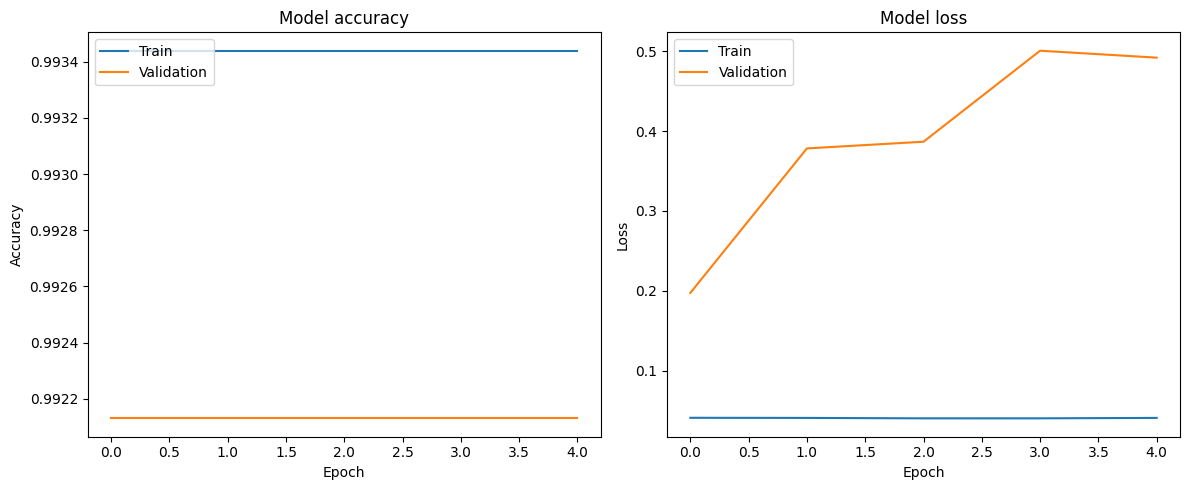

In [ ]:
plot_model_metrics(history_noise)

In [ ]:
import numpy as np
from tensorflow.keras.backend import clear_session

def calculate_accuracy(rebuild_model_func, rebuild_model_args, test_images, test_labels, threshold=0.5, num_runs=5):
    """
    Evaluate the model over a number of runs and return the average accuracy.

    :param rebuild_model_func: Function to rebuild the model.
    :param rebuild_model_args: Positional arguments for the rebuild model function.
    :param rebuild_model_kwargs: Keyword arguments for the rebuild model function.
    :param test_images: Array of test images.
    :param test_labels: Array of true labels for the test images.
    :param threshold: Threshold to convert predicted probabilities to binary predictions.
    :param num_runs: Number of runs to perform.
    :return: Average accuracy over the specified number of runs.
    """
    total_accuracy = 0

    # Perform training and evaluation in a loop
    for run in range(num_runs):
        # Reset the session
        clear_session()
        face_model = build_model()
        # Rebuild the model with the provided function and arguments
        model = add_noise_to_specific_layers(face_model, noisy_layers, noise_level=0.8)

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Make predictions using the model
        predictions = model.predict(test_images)

        # Convert predictions to binary using the defined threshold
        binary_predictions = (predictions > threshold).astype(int).flatten()

        # Calculate accuracy
        num_correct = np.sum(binary_predictions == test_labels)
        accuracy = num_correct / len(test_labels)

        # Accumulate total accuracy
        total_accuracy += accuracy
        print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

    # Calculate the average accuracy over all runs
    avg_accuracy = total_accuracy / num_runs
    print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")
    return avg_accuracy, binary_predictions

### Noise Model [GRAD CAM Layers]

#### Normal

In [ ]:
accuracy, binary_predictions_normal = calculate_accuracy(rebuild_model_func=add_noise_to_specific_layers,
                                                  rebuild_model_args=(face_model, noisy_layers, 0.8),
                                                  test_images=X_test,
                                                  test_labels=y_test)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 98ms/step
Run 1: Accuracy = 13.22%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 2: Accuracy = 86.48%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 3: Accuracy = 22.40%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 67.17%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 5: Accuracy = 0.53%
Average Accuracy over 5 runs: 37.96%


Precision: 0
Recall: 0.0
F1 Score: 0


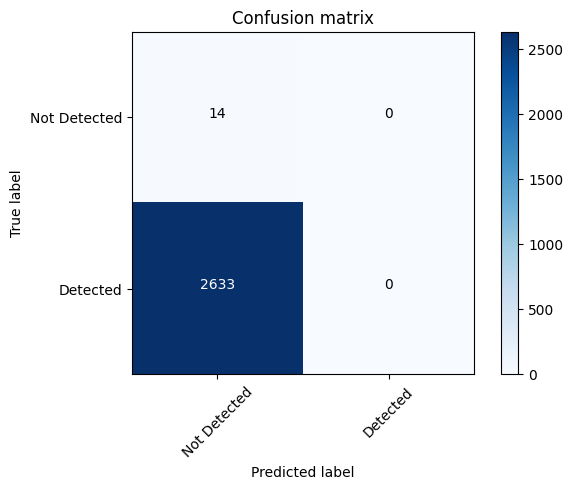

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions_normal

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyebrows

In [ ]:
clear_session()
face_model = build_model()
accuracy, binary_predictions_brows = calculate_accuracy(rebuild_model_func=add_noise_to_specific_layers,
                                                  rebuild_model_args=(face_model, noisy_layers, 0.8),
                                                  test_images=X_test_brows,
                                                  test_labels=y_test_brows)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 1: Accuracy = 31.24%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 2: Accuracy = 31.24%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 3: Accuracy = 31.24%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 31.24%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 31.24%
Average Accuracy over 5 runs: 31.24%


Precision: 0.9915254237288136
Recall: 0.31117021276595747
F1 Score: 0.4736842105263159


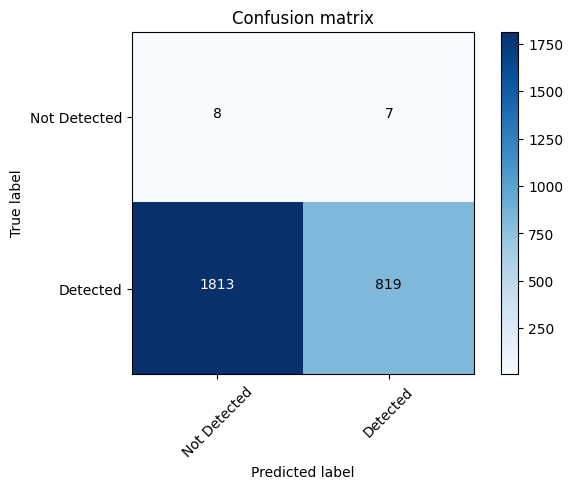

In [ ]:
# performace on normal data
y_true = y_test_brows
y_pred = binary_predictions_brows

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
clear_session()
face_model = build_model()
accuracy, binary_predictions_eyes = calculate_accuracy(rebuild_model_func=add_noise_to_specific_layers,
                                                  rebuild_model_args=(face_model, noisy_layers, 0.8),
                                                  test_images=X_test_eyes,
                                                  test_labels=y_test_eyes)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 1: Accuracy = 72.80%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 2: Accuracy = 72.80%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 3: Accuracy = 72.80%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 72.80%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 72.80%
Average Accuracy over 5 runs: 72.80%


Precision: 0.9948266942576306
Recall: 0.7303456133687809
F1 Score: 0.8423127463863338


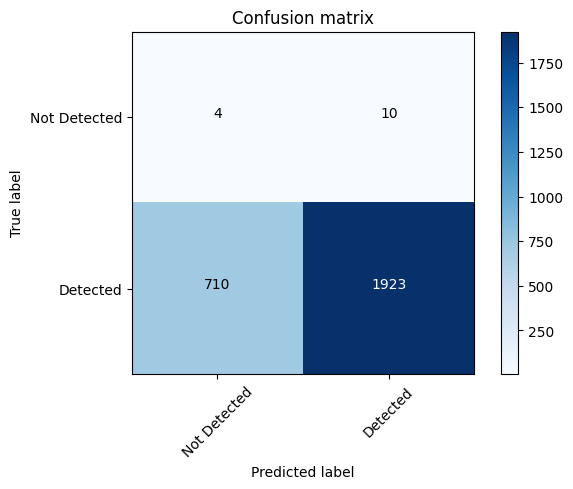

In [ ]:
# performace on normal data
y_true = y_test_eyes
y_pred = binary_predictions_eyes

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
clear_session()
# face_model = build_model()
accuracy, binary_predictions_noise = calculate_accuracy(rebuild_model_func=add_noise_to_specific_layers,
                                                  rebuild_model_args=(face_model, noisy_layers, 0.8),
                                                  test_images=X_test_nose,
                                                  test_labels=y_test_nose)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 1: Accuracy = 73.55%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 98ms/step
Run 2: Accuracy = 73.55%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 3: Accuracy = 73.55%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 73.55%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 5: Accuracy = 73.55%
Average Accuracy over 5 runs: 73.55%


Precision: 1.0
Recall: 0.07823775161412837
F1 Score: 0.14512152166255723


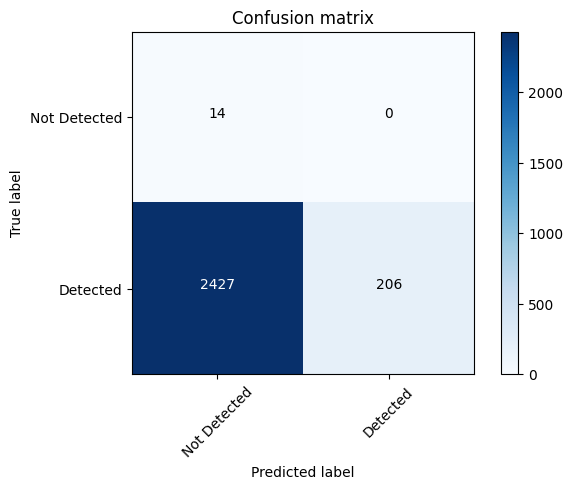

In [ ]:
# performace on normal data
y_true = y_test_nose
y_pred = binary_predictions_nose

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Mouth

In [ ]:
clear_session()
# face_model = build_model()
accuracy, binary_predictions_noise = calculate_accuracy(rebuild_model_func=add_noise_to_specific_layers,
                                                  rebuild_model_args=(face_model, noisy_layers, 0.8),
                                                  test_images=X_test_nose,
                                                  test_labels=y_test_nose)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 13.07%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 2: Accuracy = 48.92%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 3: Accuracy = 82.32%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 4: Accuracy = 44.35%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 87.68%
Average Accuracy over 5 runs: 55.27%


Precision: 1.0
Recall: 0.07823775161412837
F1 Score: 0.14512152166255723


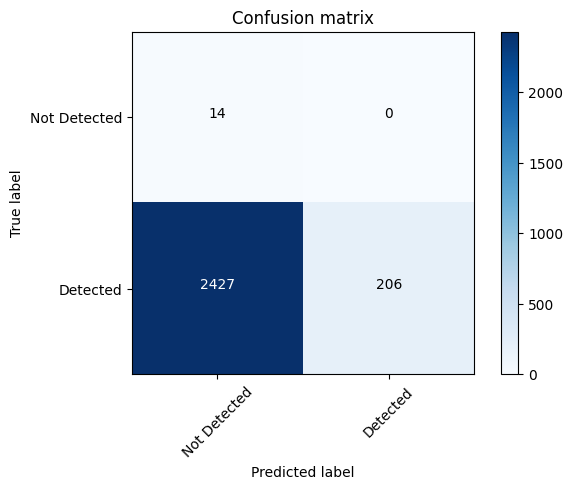

In [ ]:
# performace on normal data
y_true = y_test_nose
y_pred = binary_predictions_nose

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

## Approach 3: Selective Dropout

In [ ]:
from keras.models import clone_model
from keras.layers import Dropout

def add_selective_dropout(base_model, dropout_layers, dropout_rate=0.5):
    """
    Adds dropout to specific layers without modifying the base model.

    :param base_model: The base Keras model.
    :param dropout_layers: A list of layer names where dropout should be added.
    :param dropout_rate: The dropout rate.
    :return: A new model with selective dropout.
    """
    # Clone the base model
    model_clone = clone_model(base_model)
    model_clone.set_weights(base_model.get_weights())

    # Rebuild model architecture and add dropout to the specified layers
    x = model_clone.input
    for layer in model_clone.layers:
        if layer.name in dropout_layers:
            # Add dropout after the specified layer
            x = Dropout(dropout_rate)(layer(x))
        else:
            x = layer(x)

    # Create the new model with selective dropout
    model_with_dropout = Model(inputs=model_clone.input, outputs=x)
    # Compile the new model as needed
    model_with_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_with_dropout

In [ ]:
clear_session()
face_model = build_model()
# Specify the layers to be ablated based on Grad-CAM results
dropout_layers = ['conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

# Build the model with feature ablation
dropout_face_model = add_selective_dropout(face_model, dropout_layers, dropout_rate=0.8)


# Display the summary to confirm the ablation layers are included
dropout_face_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[1][0]']                
                                )                                                                 
                                                                                            

In [ ]:
import numpy as np
from tensorflow.keras.backend import clear_session

def calculate_accuracy(test_images, test_labels, threshold=0.5, num_runs=5):
    """
    Evaluate the model over a number of runs and return the average accuracy.

    :param rebuild_model_func: Function to rebuild the model.
    :param rebuild_model_args: Positional arguments for the rebuild model function.
    :param rebuild_model_kwargs: Keyword arguments for the rebuild model function.
    :param test_images: Array of test images.
    :param test_labels: Array of true labels for the test images.
    :param threshold: Threshold to convert predicted probabilities to binary predictions.
    :param num_runs: Number of runs to perform.
    :return: Average accuracy over the specified number of runs.
    """
    total_accuracy = 0

    # Perform training and evaluation in a loop
    for run in range(num_runs):

        # Reset the session
        clear_session()
        face_model = build_model()
        # Rebuild the model with the provided function and arguments
        model = add_selective_dropout(face_model, dropout_layers, dropout_rate=0.8)

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Make predictions using the model
        predictions = model.predict(test_images)

        # Convert predictions to binary using the defined threshold
        binary_predictions = (predictions > threshold).astype(int).flatten()

        # Calculate accuracy
        num_correct = np.sum(binary_predictions == test_labels)
        accuracy = num_correct / len(test_labels)

        # Accumulate total accuracy
        total_accuracy += accuracy
        print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

    # Calculate the average accuracy over all runs
    avg_accuracy = total_accuracy / num_runs
    print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")
    return avg_accuracy, binary_predictions

#### Normal

In [ ]:
_, binary_predictions_normal = calculate_accuracy(X_test, y_test, threshold=0.5, num_runs=5)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 26.60%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 2: Accuracy = 5.93%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 3: Accuracy = 96.94%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 4: Accuracy = 73.82%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 31.43%
Average Accuracy over 5 runs: 46.94%


Precision: 0.9939613526570048
Recall: 0.3125712115457653
F1 Score: 0.4755850910141578


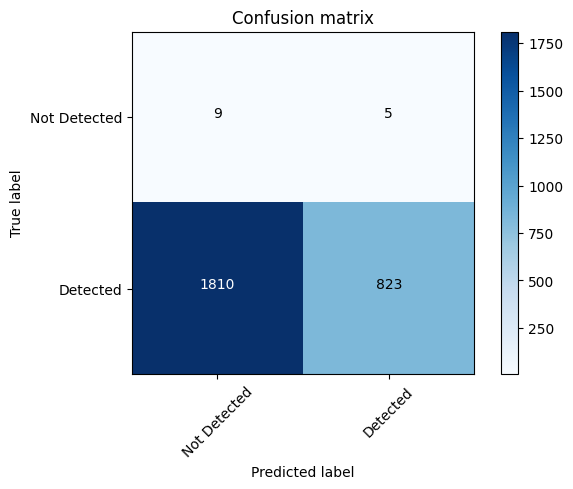

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions_normal

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyebrows

In [ ]:
_, binary_predictions_brows = calculate_accuracy(X_test_brows, y_test_brows, threshold=0.5, num_runs=5)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 1: Accuracy = 20.36%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 2: Accuracy = 52.81%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 3: Accuracy = 45.83%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 4: Accuracy = 3.40%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 61.05%
Average Accuracy over 5 runs: 36.69%


Precision: 0.9938309685379395
Recall: 0.6120820668693009
F1 Score: 0.7575828826710557


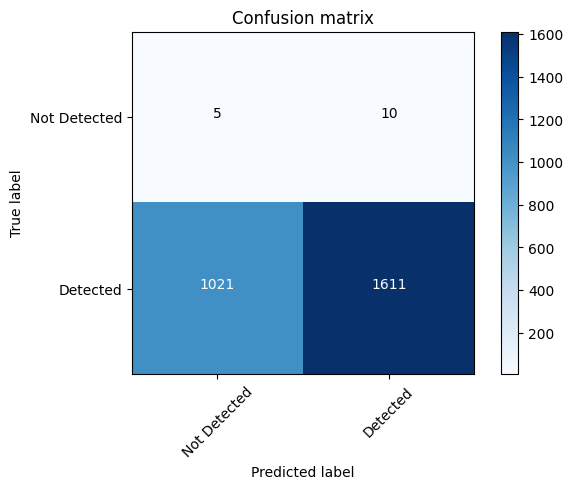

In [ ]:
# performace on normal data
y_true = y_test_brows
y_pred = binary_predictions_brows

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
_, binary_predictions_eyes = calculate_accuracy(X_test_eyes, y_test_eyes, threshold=0.5, num_runs=5)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 91ms/step
Run 1: Accuracy = 63.47%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 2: Accuracy = 72.46%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 92ms/step
Run 3: Accuracy = 15.04%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 4: Accuracy = 63.47%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 86.78%
Average Accuracy over 5 runs: 60.24%


Precision: 0.9947984395318595
Recall: 0.8716293201671098
F1 Score: 0.9291497975708503


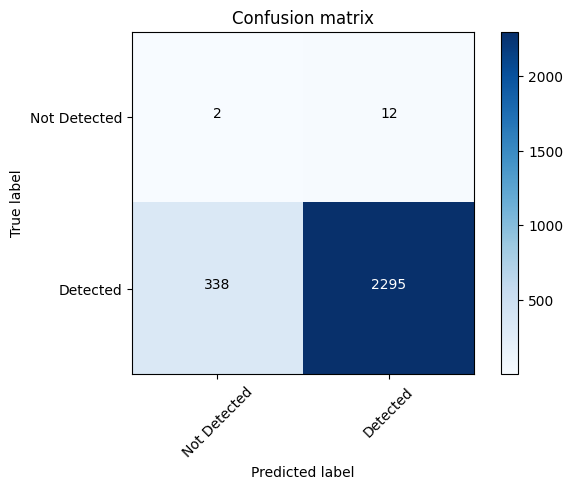

In [ ]:
# performace on normal data
y_true = y_test_eyes
y_pred = binary_predictions_eyes

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
_, binary_predictions_nose = calculate_accuracy(X_test_nose, y_test_nose, threshold=0.5, num_runs=5)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 1: Accuracy = 94.79%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 2: Accuracy = 92.82%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 3: Accuracy = 2.53%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 40.01%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 97.92%
Average Accuracy over 5 runs: 65.61%


Precision: 0.9950076804915514
Recall: 0.9840486137485758
F1 Score: 0.9894978040863089


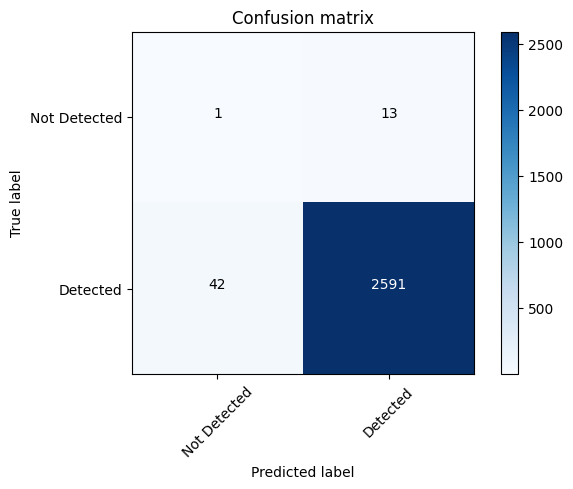

In [ ]:
# performace on normal data
y_true = y_test_nose
y_pred = binary_predictions_nose

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Mouth

In [ ]:
_, binary_predictions_mouth = calculate_accuracy(X_test_mouth, y_test_mouth, threshold=0.5, num_runs=5)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 21.57%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 94ms/step
Run 2: Accuracy = 5.67%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 95ms/step
Run 3: Accuracy = 94.45%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 59.88%


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


83/83 [==============================] - 8s 97ms/step
Run 5: Accuracy = 19.00%
Average Accuracy over 5 runs: 40.11%


Precision: 0.9938650306748467
Recall: 0.18500190331176247
F1 Score: 0.3119383825417202


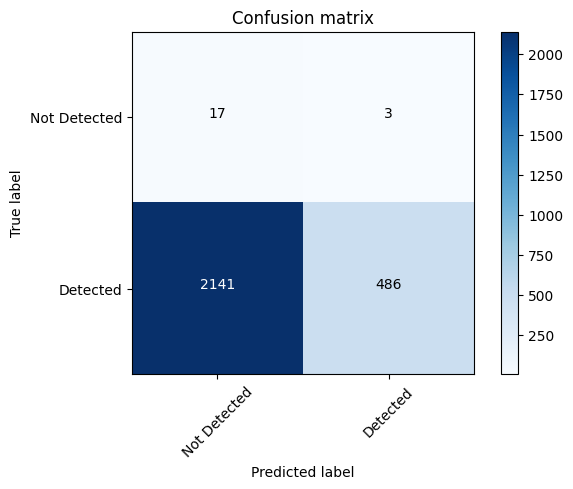

In [ ]:
# performace on normal data
y_true = y_test_mouth
y_pred = binary_predictions_mouth

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

# Approach 4: Combine dropout, ablation, and noise

In [ ]:
clear_session()
# Specify the layers to be ablated based on Grad-CAM results
layers = ['conv3_2', 'conv4_3', 'conv5_3']

# Add feature ablation
ablation = build_model_with_ablation(layers)
# Add noise
noise = add_noise_to_specific_layers(ablation, noisy_layers, noise_level=0.8)
# Add dropout
dropout = add_selective_dropout(noise , dropout_layers, dropout_rate=0.8)
dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dropout.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.floa

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 ablated_input_1 (Lambda)       (None, 224, 224, 3)  0           ['input_1[2][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['ablated_input_1[1][0]']        
                                )                                                                 
                                                                                                  
 ablated_conv1_1 (Lambda)       (None, 224, 224, 64  0           ['conv1_1[1][0]']          

#### Normal

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 90ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.22667170381564034


Precision: 0.9966101694915255
Recall: 0.22331940751993923
F1 Score: 0.3648774433757369


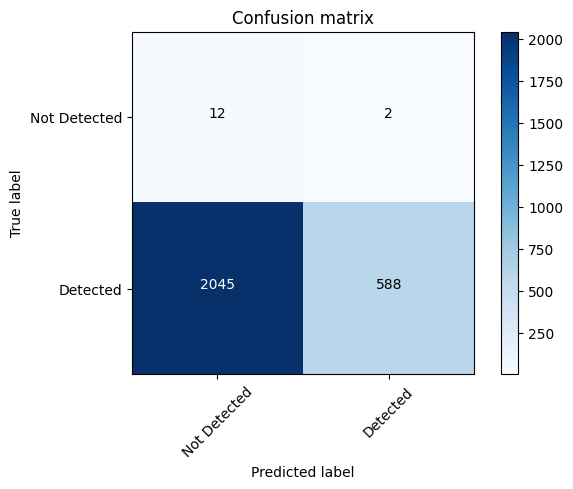

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyebrows

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_brows # Load your test images here
test_labels = y_test_brows # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 7s 90ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.3944087646392142


Precision: 0.9951876804619827
Recall: 0.39285714285714285
F1 Score: 0.5633342413511305


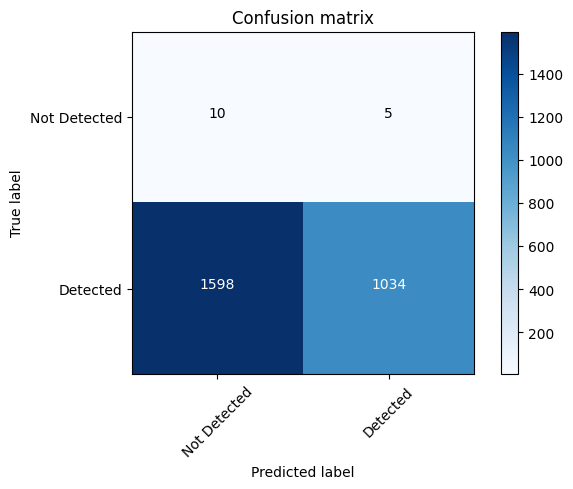

In [ ]:
# performace on normal data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_eyes # Load your test images here
test_labels = y_test_eyes # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 92ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.33282961843596526


Precision: 0.9931740614334471
Recall: 0.33156095708317507
F1 Score: 0.4971526195899772


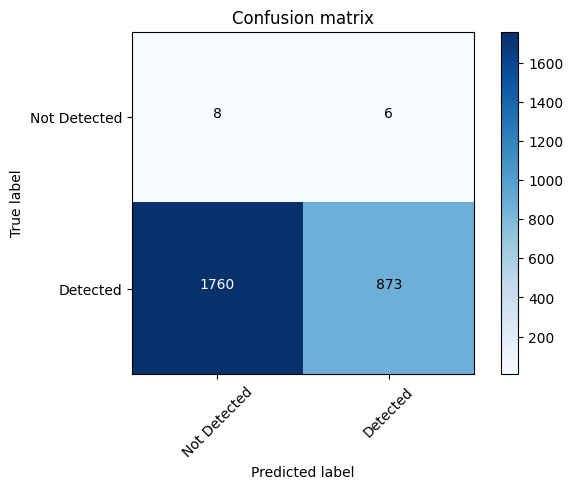

In [ ]:
# performace on normal data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_nose # Load your test images here
test_labels = y_test_nose # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 92ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.28560634680770686


Precision: 0.9894459102902374
Recall: 0.284846183061147
F1 Score: 0.44234739015039815


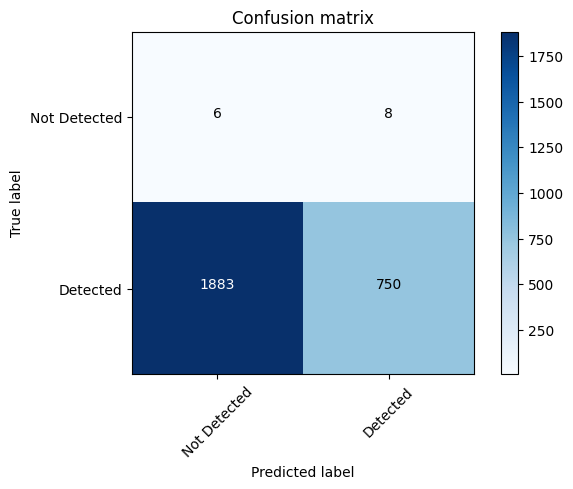

In [ ]:
# performace on normal data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Mouth

In [ ]:
# Test the ablated model - normal data
# Load the test dataset
test_images = X_test_mouth # Load your test images here
test_labels = y_test_mouth # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = dropout.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]:", accuracy)

83/83 [==============================] - 8s 94ms/step
Face model With feature ablation, noise injection, and selective dropout [Layers: conv3_2, conv4_2, conv5_3]: 0.2100491122024934


Precision: 0.9890510948905109
Recall: 0.20631899505138943
F1 Score: 0.34141732283464565


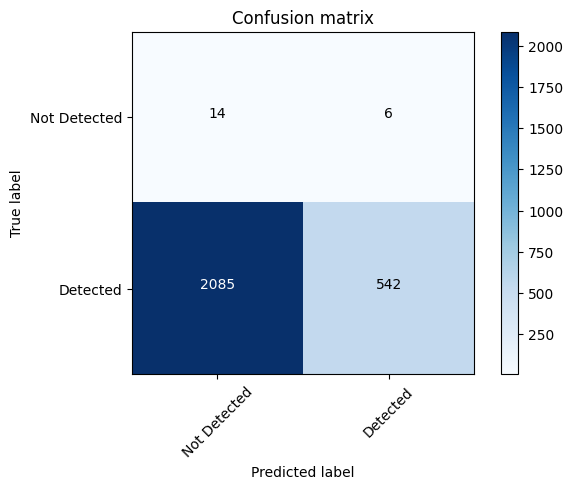

In [ ]:
# performace on normal data
y_true = test_labels
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

# Creating Data for Neuron Manipulation

In [ ]:
import cv2
import dlib
import numpy as np

# Load dlib's pre-trained face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Make sure to download this

In [ ]:
# Initialize dlib's face detector (HOG-based) and load the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')  # Path to the model

def get_feature_mask(image, feature_indices, scale=1.0):
    """
    Creates a mask for the specified feature by enlarging the bounding box around the detected feature points.
    Args:
    image (numpy array): The original image.
    feature_indices (list): A list of landmark indices that define the feature.
    scale (float): How much to scale the bounding box of the feature for the mask.

    Returns:
    numpy array: The mask with the specified feature highlighted.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)

    if faces:
        face = faces[0]
        landmarks = predictor(gray, face)
        feature_coords = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices])
        feature_bbox = cv2.boundingRect(feature_coords)
        x, y, w, h = feature_bbox
        x_center, y_center = x + w // 2, y + h // 2
        new_width, new_height = int(w * scale), int(h * scale)
        x, y = int(x_center - new_width // 2), int(y_center - new_height // 2)

        mask = np.zeros_like(image)
        cv2.rectangle(mask, (x, y), (x + new_width, y + new_height), (255, 255, 255), -1)
        return mask
    else:
        # If no faces are detected, return an empty mask
        return np.zeros_like(image)

def blur_except_feature(image, feature_indices, scale=1.0):
    """
    Blurs the entire image except for the specified feature.
    """
    mask = get_feature_mask(image, feature_indices, scale)
    blurred_image = cv2.GaussianBlur(image, (21, 21), 0)
    final_image = np.where(mask == np.array([255, 255, 255]), image, blurred_image)
    return final_image

In [ ]:
def process_images(images, feature_indices, scale=1.0):
    # Loop over each image and process it
    processed_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed_img = blur_except_feature(img, feature_indices, scale)
        processed_images.append(processed_img)
    return processed_images

In [ ]:
# Eyebrows indices according to dlib's 68 facial landmarks
eyebrows_indices = list(range(17, 27))  # Eyebrows
# Eyes indices according to dlib's 68 facial landmarks
eyes_indices = list(range(36, 48))  # Eyes, including both the left and right eyes
# Nose indices according to dlib's 68 facial landmarks
nose_indices = list(range(27, 36))  # Nose
# Mouth indices according to dlib's 68 facial landmarks
mouth_indices = list(range(48, 68))  # Mouth

In [ ]:
# Process images to create feature-specific datasets
eyebrows_images = process_images(X_val[:1], eyebrows_indices, scale=1.5)
eyes_images = process_images(X_val[:1], eyes_indices, scale=1.5)
nose_images = process_images(X_val[:1], nose_indices, scale=1.5)
mouth_images = process_images(X_val[:1], mouth_indices, scale=1.5)

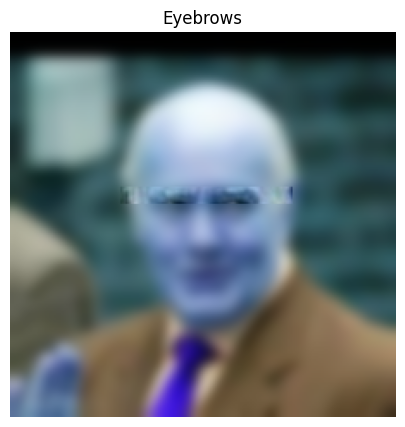

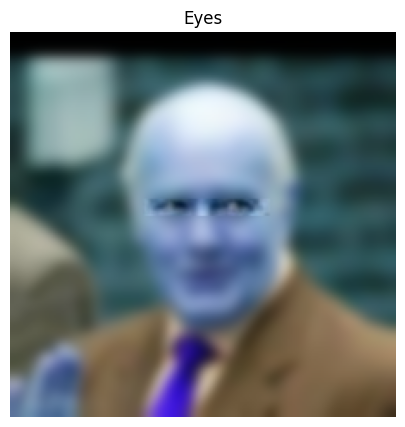

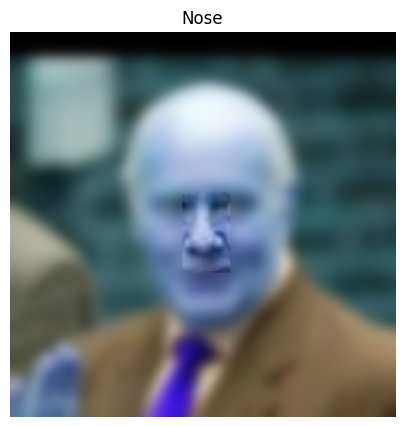

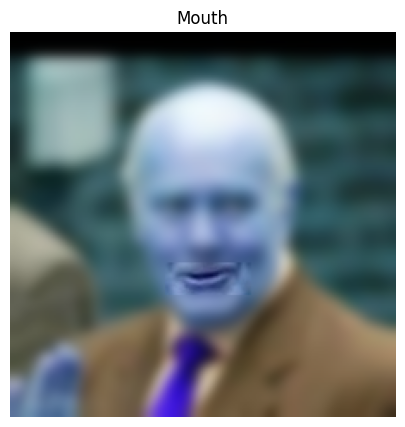

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, title):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.show()

# Show processed images
show_images(eyebrows_images, "Eyebrows")
show_images(eyes_images, "Eyes")
show_images(nose_images, "Nose")
show_images(mouth_images, "Mouth")

# Functions that help us find neurons that responsible for detecting features

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
feature_eyes = np.array([img_to_array(image) for image in eyes_images])  # 'eyes_images' should be your dataset of images
feature_eyebrows = np.array([img_to_array(image) for image in eyebrows_images])  # 'eyebrows_images' should be your dataset of images
feature_nose = np.array([img_to_array(image) for image in nose_images])  # 'nose_images' should be your dataset of images
feature_mouth = np.array([img_to_array(image) for image in mouth_images])  # 'mouth_images' should be your dataset of images

In [ ]:
def print_neurons_indices(neurons_indices_dict):
    for layer_name, neurons in neurons_indices_dict.items():
        print(f"Neurons in layer {layer_name} responsible for detecting the feature:", neurons)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def get_activations(model, layer_name, input_images):
    # Ensure input_images is 4D (batch_size, height, width, channels)
    if input_images.ndim == 3:
        input_images = np.expand_dims(input_images, axis=0)

    # Create a model that returns the outputs of the specified layer
    layer_output = model.get_layer(layer_name).output
    activation_model = Model(inputs=model.input, outputs=layer_output)

    # Predict and collect activations for the batch of images
    activations = activation_model.predict(input_images)
    return activations

def find_responsible_neurons(activations, threshold=0.75):
    # Assuming activations shape is (batch, height, width, channels)
    # Calculate the mean activation across all spatial dimensions and the batch
    mean_activation = np.mean(activations, axis=(0, 1, 2))

    # Threshold based on a percentage of the maximum activation to find highly activated neurons
    threshold_value = np.max(mean_activation) * threshold
    active_neurons = np.where(mean_activation >= threshold_value)[0]

    return active_neurons.tolist()

# Example usage:
# Model and layer to analyze
layer_name = 'conv1_1'

# Getting activations
activations = get_activations(face_model, layer_name, feature_eyes)

# Finding responsible neurons
responsible_neurons = find_responsible_neurons(activations)

print("Responsible Neurons:", responsible_neurons)


1/1 [==============================] - 0s 47ms/step
Responsible Neurons: [38, 46, 47, 55]


# Custom Layer for Neuron Manipulation

In [ ]:
from keras.layers import Layer
import keras.backend as K
import numpy as np

class NeuronManipulationLayer(Layer):
    def __init__(self, neuron_indices, manipulation_values, **kwargs):
        """
        A custom Keras layer to manipulate specific neurons by adding a constant value.

        :param neuron_indices: Indices of the neurons to manipulate.
        :param manipulation_values: Values to add to the neuron outputs. Can be positive (to activate)
                                    or negative (to inhibit).
        """
        super().__init__(**kwargs)
        self.neuron_indices = neuron_indices
        self.manipulation_values = manipulation_values
        self.manipulation_vector = None

    def build(self, input_shape):
        # The number of filters in the previous layer determines the size of the manipulation vector
        num_filters = input_shape[-1]  # Assuming the last dimension in the input shape is the channel/filter dimension
        manipulation_vector = np.zeros(num_filters)  # Initialize a vector of zeros with the same size as the number of filters
        # Set the manipulation values for specified neurons
        for index, value in zip(self.neuron_indices, self.manipulation_values):
            if index < num_filters:
                manipulation_vector[index] = value
        # Convert to a Keras variable and add as a layer weight
        self.manipulation_vector = K.variable(manipulation_vector, name='neuron_manipulation')
        self._trainable_weights.append(self.manipulation_vector)

    def call(self, inputs, **kwargs):
        # Add the manipulation vector to the input along the last dimension
        return inputs + self.manipulation_vector

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'neuron_indices': self.neuron_indices,
            'manipulation_values': self.manipulation_values,
        })
        return config

In [ ]:
# Example usage in a model
from keras.models import Model

def build_model_with_manipulation(base_model, layer_name, neuron_indices, manipulation_values):
    """
    Build a new model with neuron manipulation applied to a specific layer.

    :param base_model: The original Keras model.
    :param layer_name: Name of the layer where neurons will be manipulated.
    :param neuron_indices: Indices of the neurons to manipulate.
    :param manipulation_values: Values to add to the neuron outputs.
    :return: A new Keras model with neuron manipulation applied.
    """
    # Clone the base model
    cloned_model = clone_model(base_model)
    cloned_model.set_weights(base_model.get_weights())

    # Find the layer to manipulate
    manipulation_layer = None
    for layer in cloned_model.layers:
        if layer.name == layer_name:
            manipulation_layer = layer
            break

    if manipulation_layer is None:
        raise ValueError(f"Layer {layer_name} not found in the model.")

    # Apply the manipulation after the specified layer
    x = manipulation_layer.output
    x = NeuronManipulationLayer(neuron_indices, manipulation_values)(x)

    # Reconnect the remaining layers
    for layer in cloned_model.layers[cloned_model.layers.index(manipulation_layer) + 1:]:
        x = layer(x)

    # Create the modified model
    model_with_manipulation = Model(inputs=cloned_model.input, outputs=x)
    model_with_manipulation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_with_manipulation

In [ ]:
# Define the manipulation values
manipulation_values_zero = [0.0]  # Zero value for no change

In [ ]:
import numpy as np
from tensorflow.keras.backend import clear_session

def calculate_accuracy(test_images, test_labels, layer_name, responsible_neurons, threshold=0.5, num_runs=5):
    """
    Evaluate the model over a number of runs and return the average accuracy.

    :param rebuild_model_func: Function to rebuild the model.
    :param rebuild_model_args: Positional arguments for the rebuild model function.
    :param rebuild_model_kwargs: Keyword arguments for the rebuild model function.
    :param test_images: Array of test images.
    :param test_labels: Array of true labels for the test images.
    :param threshold: Threshold to convert predicted probabilities to binary predictions.
    :param num_runs: Number of runs to perform.
    :return: Average accuracy over the specified number of runs.
    """
    total_accuracy = 0

    # Perform training and evaluation in a loop
    for run in range(num_runs):

        # Reset the session
        clear_session()
        face_model = build_model()
        # Rebuild the model with the provided function and arguments
        model = build_model_with_manipulation(face_model, layer_name, responsible_neurons, manipulation_values_zero)

        # Compile the model
        # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Make predictions using the model
        predictions = model.predict(test_images)

        # Convert predictions to binary using the defined threshold
        binary_predictions = (predictions > threshold).astype(int).flatten()

        # Calculate accuracy
        num_correct = np.sum(binary_predictions == test_labels)
        accuracy = num_correct / len(test_labels)

        # Accumulate total accuracy
        total_accuracy += accuracy
        print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

    # Calculate the average accuracy over all runs
    avg_accuracy = total_accuracy / num_runs
    print(f"Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")
    return avg_accuracy, binary_predictions

## Neuron Manipulation: Later Layer (conv5_3)

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layer_name = 'conv5_3'
activations_brows = get_activations(face_model, 'conv5_3', feature_eyebrows)
activations_eyes = get_activations(face_model, 'conv5_3', feature_eyes)
activations_nose = get_activations(face_model, 'conv5_3', feature_nose)
activations_mouth = get_activations(face_model, 'conv5_3', feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 128ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[21, 282]
[282]
[21, 282]
[282]


In [ ]:
clear_session()
face_model = build_model()
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

#### Eyebrows

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5
for run in range(num_runs):
    clear_session()
    face_model = build_model()
    brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

    predictions = brows_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 96ms/step
Run 1: Accuracy = 3.17%
83/83 [==============================] - 8s 97ms/step
Run 2: Accuracy = 90.18%
83/83 [==============================] - 8s 96ms/step
Run 3: Accuracy = 95.47%
83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 99.06%
83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 27.77%
[LATER LAYER] Average Accuracy over 5 runs: 63.13%


Precision: 0.9948320413436692
Recall: 0.43866312191416634
F1 Score: 0.6088560885608857


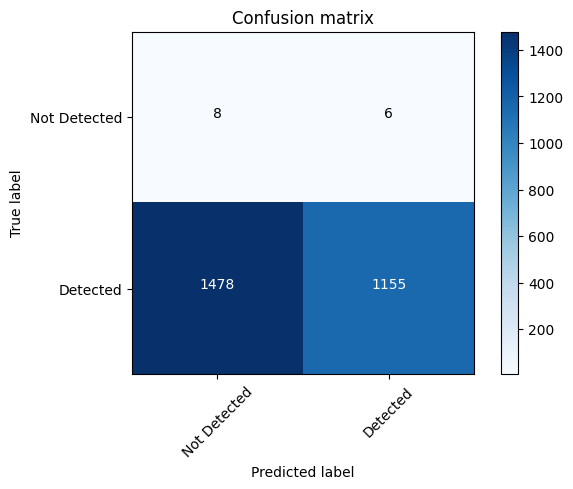

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5
for run in range(num_runs):
    clear_session()
    face_model = build_model()
    eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

    predictions = eyes_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 93ms/step
Run 1: Accuracy = 78.01%
83/83 [==============================] - 8s 93ms/step
Run 2: Accuracy = 12.01%
83/83 [==============================] - 8s 94ms/step
Run 3: Accuracy = 65.73%
83/83 [==============================] - 8s 95ms/step
Run 4: Accuracy = 1.74%
83/83 [==============================] - 8s 96ms/step
Run 5: Accuracy = 71.74%
[LATER LAYER] Average Accuracy over 5 runs: 45.85%


Precision: 0.9952706253284288
Recall: 0.7193315609570832
F1 Score: 0.8350970017636684


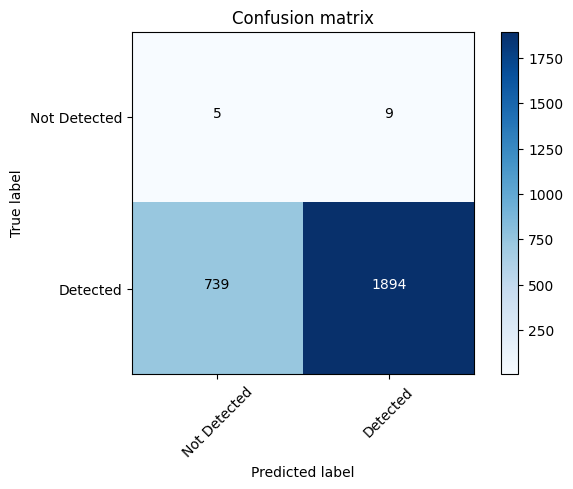

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

    predictions = nose_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 96ms/step
Run 1: Accuracy = 75.07%
83/83 [==============================] - 8s 96ms/step
Run 2: Accuracy = 33.02%
83/83 [==============================] - 8s 96ms/step
Run 3: Accuracy = 3.55%
83/83 [==============================] - 8s 95ms/step
Run 4: Accuracy = 88.18%
83/83 [==============================] - 8s 95ms/step
Run 5: Accuracy = 61.50%
[LATER LAYER] Average Accuracy over 5 runs: 52.26%


Precision: 0.9932762836185819
Recall: 0.6171667299658185
F1 Score: 0.7613024127430311


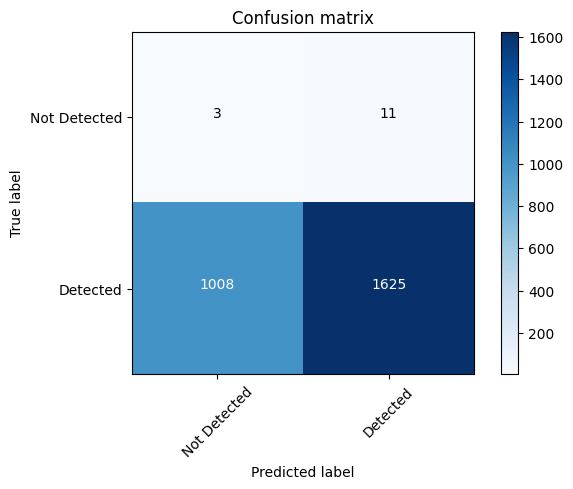

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Mouth

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

    predictions = mouth_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 95ms/step
Run 1: Accuracy = 99.47%
83/83 [==============================] - 8s 95ms/step
Run 2: Accuracy = 44.77%
83/83 [==============================] - 8s 96ms/step
Run 3: Accuracy = 77.60%
83/83 [==============================] - 8s 96ms/step
Run 4: Accuracy = 36.38%
83/83 [==============================] - 8s 95ms/step
Run 5: Accuracy = 95.92%
[LATER LAYER] Average Accuracy over 5 runs: 70.83%


Precision: 0.9952922714790113
Recall: 0.9635396885681732
F1 Score: 0.9791586260131223


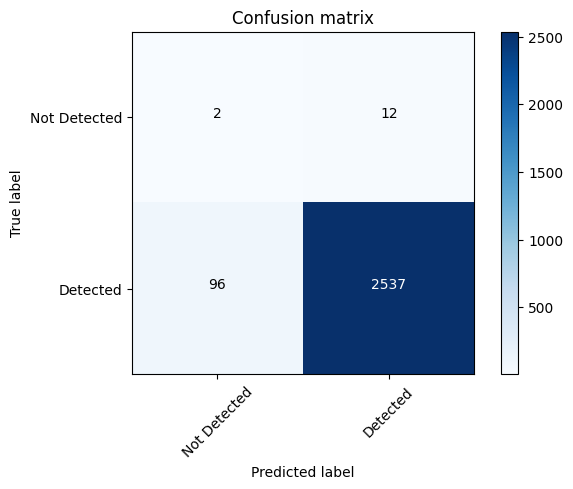

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

# Neuron Manipulation: Early Layer [conv3_2]

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layer_name = 'conv3_2' # in the early layers, this layer shows the most activation for neurons for each feature - deactivate the neurons in this layer to simulate a deficit
activations_brows = get_activations(face_model, 'conv3_2', feature_eyebrows)
activations_eyes = get_activations(face_model, 'conv3_2', feature_eyes)
activations_nose = get_activations(face_model, 'conv3_2', feature_nose)
activations_mouth = get_activations(face_model, 'conv3_2', feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 79ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[2, 16, 104, 110, 142, 144, 205, 219, 225, 231, 238]
[2, 16, 104, 110, 205, 219, 225, 231, 238]
[2, 16, 104, 110, 142, 144, 205, 219, 225, 231, 238]
[2, 16, 104, 110, 142, 205, 219, 225, 231, 238]


In [ ]:
clear_session()
face_model = build_model()
# for eyebrows
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for eyes
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for nose
nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
# for mouth
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

#### Eyebrows

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

    predictions = brows_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 92ms/step
Run 1: Accuracy = 87.16%
83/83 [==============================] - 8s 92ms/step
Run 2: Accuracy = 74.76%
83/83 [==============================] - 8s 92ms/step
Run 3: Accuracy = 9.41%
83/83 [==============================] - 8s 92ms/step
Run 4: Accuracy = 14.28%
83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 99.09%
[LATER LAYER] Average Accuracy over 5 runs: 56.94%


Precision: 0.9946909366704588
Recall: 0.996202050892518
F1 Score: 0.9954459203036053


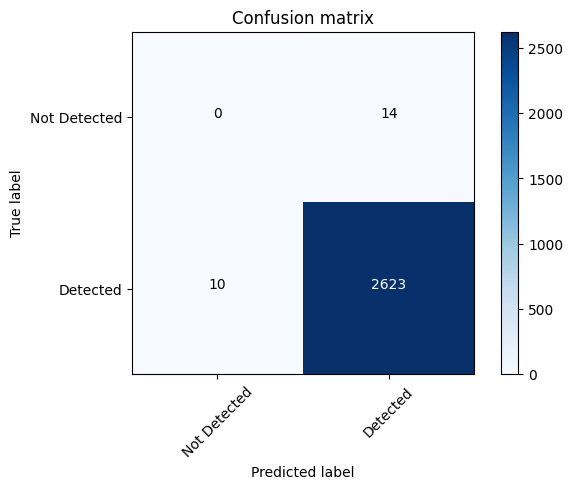

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

    predictions = eyes_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 49.94%
83/83 [==============================] - 8s 90ms/step
Run 2: Accuracy = 77.30%
83/83 [==============================] - 8s 91ms/step
Run 3: Accuracy = 63.66%
83/83 [==============================] - 8s 90ms/step
Run 4: Accuracy = 40.54%
83/83 [==============================] - 8s 91ms/step
Run 5: Accuracy = 56.03%
[LATER LAYER] Average Accuracy over 5 runs: 57.49%


Precision: 0.9932840832773674
Recall: 0.5617166729965819
F1 Score: 0.7176128093158661


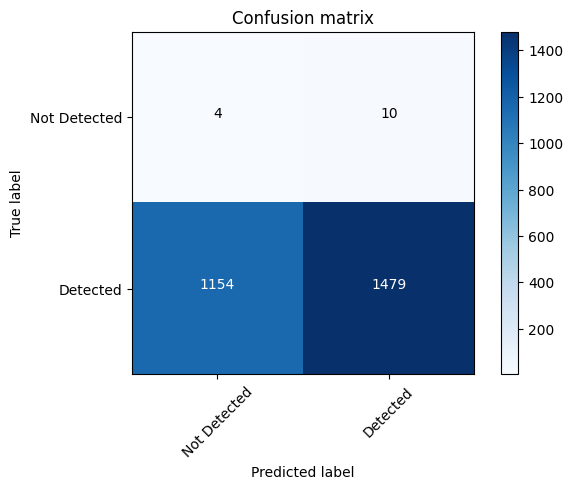

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

    predictions = nose_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 17.15%
83/83 [==============================] - 8s 90ms/step
Run 2: Accuracy = 30.34%
83/83 [==============================] - 8s 91ms/step
Run 3: Accuracy = 90.29%
83/83 [==============================] - 8s 91ms/step
Run 4: Accuracy = 18.59%
83/83 [==============================] - 8s 92ms/step
Run 5: Accuracy = 96.11%
[LATER LAYER] Average Accuracy over 5 runs: 50.49%


Precision: 0.9949139280125195
Recall: 0.9658184580326623
F1 Score: 0.980150317980343


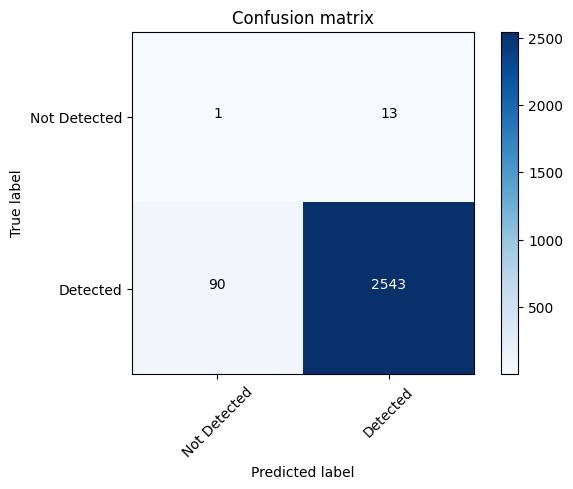

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Mouth

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

    predictions = mouth_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 92ms/step
Run 1: Accuracy = 83.57%
83/83 [==============================] - 8s 92ms/step
Run 2: Accuracy = 58.90%
83/83 [==============================] - 8s 92ms/step
Run 3: Accuracy = 52.21%
83/83 [==============================] - 8s 93ms/step
Run 4: Accuracy = 0.72%
83/83 [==============================] - 8s 93ms/step
Run 5: Accuracy = 37.93%
[LATER LAYER] Average Accuracy over 5 runs: 46.66%


Precision: 0.9940119760479041
Recall: 0.3782757311052032
F1 Score: 0.5480055020632738


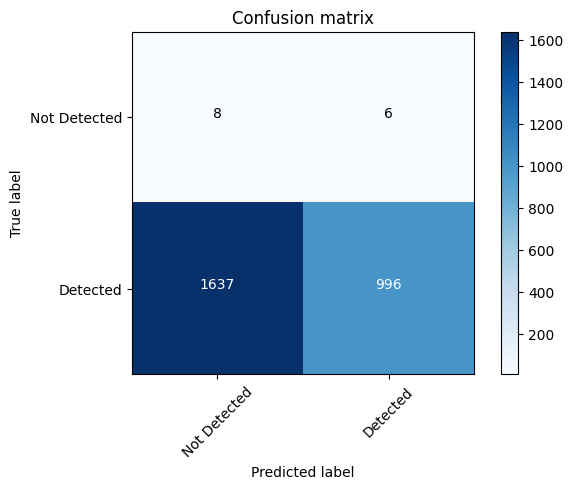

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

## Neuron Manipulation: Middle Layer [conv4_2]

In [ ]:
clear_session()
face_model = build_model()

In [ ]:
layer_name = 'conv4_2' # in the early layers, this layer shows the most activation for neurons for each feature - deactivate the neurons in this layer to simulate a deficit
activations_brows = get_activations(face_model, layer_name , feature_eyebrows)
activations_eyes = get_activations(face_model, layer_name, feature_eyes)
activations_nose = get_activations(face_model, layer_name, feature_nose)
activations_mouth = get_activations(face_model, layer_name, feature_mouth)
responsible_neurons_brows = find_responsible_neurons(activations_brows)
responsible_neurons_eyes = find_responsible_neurons(activations_eyes)
responsible_neurons_nose = find_responsible_neurons(activations_nose)
responsible_neurons_mouth = find_responsible_neurons(activations_mouth)

1/1 [==============================] - 0s 96ms/step


In [ ]:
print(responsible_neurons_brows)
print(responsible_neurons_eyes)
print(responsible_neurons_nose)
print(responsible_neurons_mouth)

[12, 47, 170, 198, 256, 275, 479]
[12, 47, 170, 198, 256, 275, 479]
[12, 47, 170, 198, 256, 275, 479]
[12, 47, 170, 198, 256, 275, 479]


In [ ]:
clear_session()
face_model = build_model()
brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

In [ ]:
clear_session()
face_model = build_model()
mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

#### Eyebrows

In [ ]:
print(layer_name)
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    brows_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_brows, manipulation_values_zero)

    predictions = brows_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

conv4_2
83/83 [==============================] - 7s 90ms/step
Run 1: Accuracy = 96.30%
83/83 [==============================] - 8s 90ms/step
Run 2: Accuracy = 98.34%
83/83 [==============================] - 8s 90ms/step
Run 3: Accuracy = 94.33%
83/83 [==============================] - 8s 90ms/step
Run 4: Accuracy = 26.48%
83/83 [==============================] - 8s 90ms/step
Run 5: Accuracy = 17.30%
[LATER LAYER] Average Accuracy over 5 runs: 66.55%


Precision: 0.9911504424778761
Recall: 0.1701481200151918
F1 Score: 0.29043760129659646


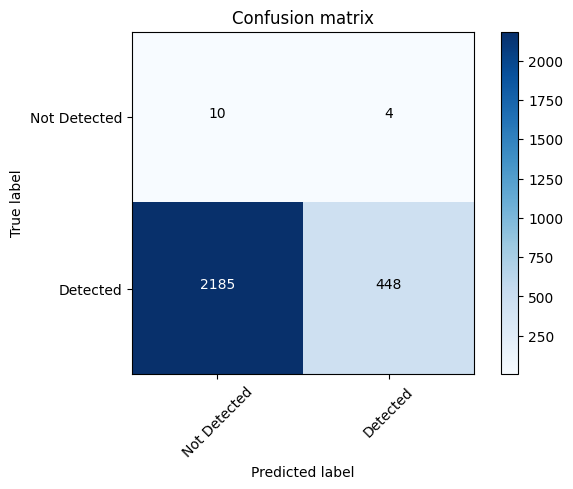

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Eyes

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    eyes_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_eyes, manipulation_values_zero)

    predictions = eyes_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 24.14%
83/83 [==============================] - 8s 90ms/step
Run 2: Accuracy = 92.41%
83/83 [==============================] - 8s 90ms/step
Run 3: Accuracy = 59.65%
83/83 [==============================] - 8s 91ms/step
Run 4: Accuracy = 20.70%
83/83 [==============================] - 8s 91ms/step
Run 5: Accuracy = 95.88%
[LATER LAYER] Average Accuracy over 5 runs: 58.56%


Precision: 0.9949019607843137
Recall: 0.9635396885681732
F1 Score: 0.9789697086629364


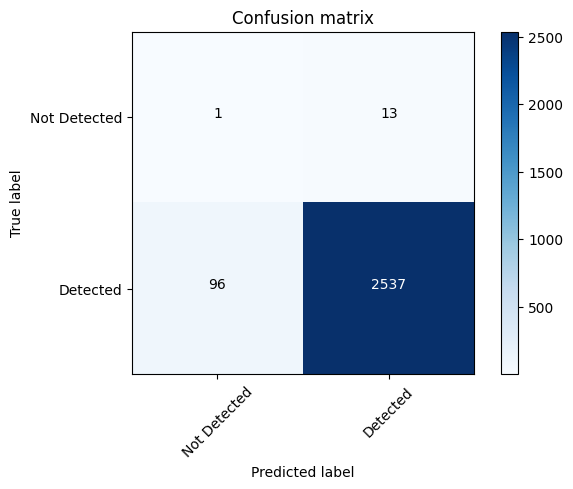

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

#### Nose

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    nose_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_nose, manipulation_values_zero)

    predictions = nose_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 7s 90ms/step
Run 1: Accuracy = 90.18%
83/83 [==============================] - 8s 90ms/step
Run 2: Accuracy = 2.64%
83/83 [==============================] - 8s 90ms/step
Run 3: Accuracy = 2.08%
83/83 [==============================] - 8s 90ms/step
Run 4: Accuracy = 67.62%
83/83 [==============================] - 8s 90ms/step
Run 5: Accuracy = 18.28%
[LATER LAYER] Average Accuracy over 5 runs: 36.16%


Precision: 0.9936974789915967
Recall: 0.1796429927838967
F1 Score: 0.3042779028626568


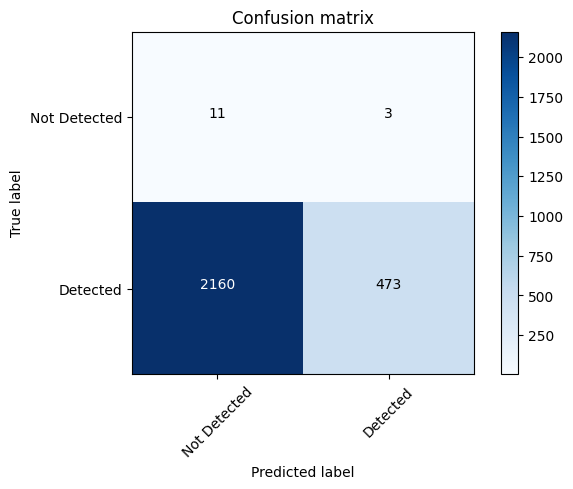

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = nose_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Nose -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 95ms/step
[MIDDLE LAYER] Nose -- manipulated neurons at CONV4_2: 0.6773706082357386


In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

# Make predictions using the model
# predictions = final_model.predict(test_images)
predictions = mouth_zero.predict(test_images)
binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

# Calculate accuracy
num_correct = 0
total_images = len(test_images)

for i in range(total_images):
    predicted_class = binary_predictions[i]
    true_class = test_labels[i]
    if predicted_class == true_class:
        num_correct += 1

accuracy = num_correct / total_images
print("[MIDDLE LAYER] Mouth -- manipulated neurons at CONV4_2:", accuracy)

83/83 [==============================] - 8s 96ms/step
[MIDDLE LAYER] Mouth -- manipulated neurons at CONV4_2: 0.2818284850774462


#### Mouth

In [ ]:
test_images = X_test # Load your test images here
test_labels = y_test # Load your test labels here

# Define a threshold for classifying as face detected
threshold = 0.5

total_accuracy = 0
num_runs = 5

for run in range(num_runs):
    clear_session()
    face_model = build_model()
    mouth_zero = build_model_with_manipulation(face_model, layer_name, responsible_neurons_mouth, manipulation_values_zero)

    predictions = mouth_zero.predict(test_images)
    binary_predictions = (predictions.max(axis=1) > threshold).astype(int)

    num_correct = np.sum(binary_predictions == test_labels)
    accuracy = num_correct / len(test_labels)

    total_accuracy += accuracy
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

avg_accuracy = total_accuracy / num_runs
print(f"[LATER LAYER] Average Accuracy over {num_runs} runs: {avg_accuracy * 100:.2f}%")

83/83 [==============================] - 8s 90ms/step
Run 1: Accuracy = 40.46%
83/83 [==============================] - 8s 91ms/step
Run 2: Accuracy = 84.70%
83/83 [==============================] - 8s 91ms/step
Run 3: Accuracy = 14.96%
83/83 [==============================] - 8s 91ms/step
Run 4: Accuracy = 0.68%
83/83 [==============================] - 8s 91ms/step
Run 5: Accuracy = 97.13%
[LATER LAYER] Average Accuracy over 5 runs: 47.59%


Precision: 0.9945841392649903
Recall: 0.9764527155336119
F1 Score: 0.9854350325795324


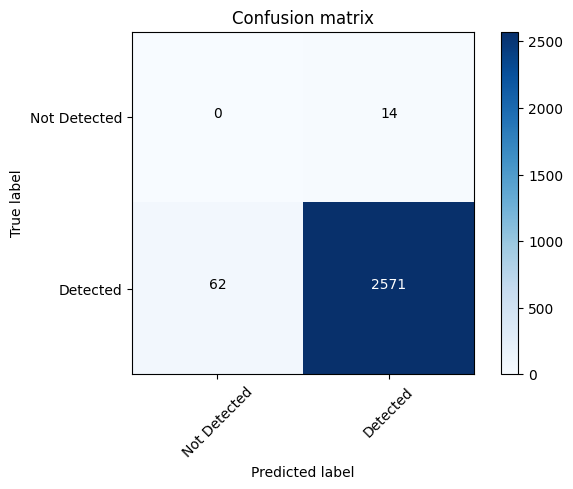

In [ ]:
# performace on normal data
y_true = y_test
y_pred = binary_predictions

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm)